In [165]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
import json
import random
from tqdm import tqdm_notebook, tqdm
from colorama import Fore, Style
from google.cloud import bigquery


%matplotlib inline
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
# from matplotlib import colors
import matplotlib.colors
import seaborn as sns
from slugify import slugify

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=500)

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.5.0
OS Darwin 17.5.0 x86_64 i386 64bit
pandas 0.24.2
numpy 1.14.3
Mon Jun 17 16:44:02 2019 PDT

## Import bigquery data

In [2]:
client = bigquery.Client.from_service_account_json('/Users/heather/Documents/forecasting-app/forecast-prophet-testing-3df528dba0ca.json')

In [3]:
data_ref = client.dataset('google_analytics_sample', project='bigquery-public-data')
ga_dataset = client.get_dataset(data_ref)

In [4]:
list_of_tables = [x.table_id for x in client.list_tables(ga_dataset)]

In [5]:
len(list_of_tables)

366

In [ ]:
query_job = client.query(
    '''
    SELECT
        date,
        sum(totals.visits),
        sum(totals.pageviews),
        sum(totals.transactions),
        sum(totals.transactionRevenue)
    FROM
        `bigquery-public-data.google_analytics_sample.{}`
    '''
).format(table)

In [ ]:
%%time
data = []

for table in tqdm(list_of_tables):
    print('TABLE:', table)
    
    query_job = client.query(
        '''
        SELECT
            date,
            sum(totals.visits),
            sum(totals.pageviews),
            sum(totals.transactions),
            sum(totals.transactionRevenue),
            trafficSource.source,
            trafficSource.campaign,
            geoNetwork.subContinent,
            geoNetwork.country,
            device.deviceCategory,
            device.browser
        FROM
            `bigquery-public-data.google_analytics_sample.{}`
        GROUP BY date,
            trafficSource.source,
            trafficSource.campaign,
            geoNetwork.subContinent,
            geoNetwork.country,
            device.deviceCategory,
            device.browser
        '''.format(table)
    )
    
    my_job_config = bigquery.job.QueryJobConfig()
    results = query_job.result().to_dataframe()
    results.columns = ['date',
                       'visits',
                       'pageviews',
                       'transactions',
                       'transactionRevenue',
                       'trafficSource',
                       'campaign',
                       'subContinent',
                       'country',
                       'deviceType',
                       'browser']
    data.append(results)
    
    df = pd.concat(data, ignore_index=True, sort=False)
#     break
    

In [ ]:
df.head()

## Simulating user_id

In [ ]:
user_dilution = 1e5
df['user_id'] = int(np.random.exponential(scale=1 * user_dilution))

In [ ]:
def simulate_user_id(row):
    user_dilution = 1e5
    user_id = int(np.random.exponential(scale=1 * user_dilution))
    return user_id

In [ ]:
df['user_id'] = df.apply(lambda x: simulate_user_id(x), axis=1)

In [ ]:
df

In [ ]:
df['user_id'].value_counts().head()

In [ ]:
df[df.user_id == 527]

### Segment by user_id and assign attributes

#### Get all possible regions

In [ ]:
%%time
region_data = []

for table in tqdm(list_of_tables):
    print('TABLE:', table)
    
    query_job = client.query(
        '''
        SELECT
            geoNetwork.region,
            geoNetwork.country,
            geoNetwork.subContinent
        FROM
            `bigquery-public-data.google_analytics_sample.{}`
        WHERE
            (geoNetwork.region != "not available in demo dataset")
            AND
            (geoNetwork.region != "(not set)");

        '''.format(table)
    )
    
    my_job_config = bigquery.job.QueryJobConfig()
    results = query_job.result().to_dataframe()
    results.columns = ['region',
                       'country',
                       'subContinent']
    region_data.append(results)
    
    df_regions = pd.concat(region_data, ignore_index=True, sort=False)
#     break
    

In [ ]:
df_regions

In [ ]:
regions_list = list(df_regions['region'])
age_list = ['under 18', '18-25', '25-35', '35-45', '45-60', 'over 60']
gender_list = ['male', 'female', 'other']

def assign_attributes_by_segment(df, regions_list, age_list, gender_list):
    '''
    Append randomly selected region, age, and gender to each user_id
    '''
    for user_id in tqdm(list(df['user_id'].unique())):
        mask = (df['user_id'] == user_id)
        masked_df
        df.loc[mask, 'region'] = random.choice(regions_list)
        df.loc[mask, 'age'] = random.choice(age_list)
        df.loc[mask, 'gender'] = random.choice(gender_list)
    
    return df

In [ ]:
df_attributes = assign_attributes_by_segment(df, regions_list, age_list, gender_list)

In [ ]:
df['region'].value_counts()

In [ ]:
# Assign random region, gender, and age to each unique user_id
df_list = []
for user in tqdm(list(df['user_id'].unique())):
    s = df[df.user_id == user].copy()
    s['region'] = random.choice(regions_list)
    s['gender'] = random.choice(gender_list)
    s['age'] = random.choice(age_list)
#     print(s)
    df_list.append(s)
df_regions_concat = pd.concat(df_list)

In [ ]:
df_regions_concat

In [ ]:
df_regions_concat.to_csv('data_for_survival_analysis.csv', index=False)

Read in CSV

In [40]:
df_regions_concat = pd.read_csv('data_for_survival_analysis.csv')

In [41]:
df_regions_concat

,date,visits,pageviews,transactions,transactionRevenue,trafficSource,campaign,deviceType,browser,user_id,region,age,gender
0,20160801,2,5.0,NaN,NaN,google,(not set),mobile,Chrome,1447,Lima Region,over 60,other
1,20160906,7,8.0,NaN,NaN,youtube.com,(not set),desktop,Safari,1447,Lima Region,over 60,other
2,20160918,13,38.0,NaN,NaN,google,(not set),mobile,Chrome,1447,Lima Region,over 60,other
3,20161027,1,1.0,NaN,NaN,Partners,Data Share Promo,mobile,Chrome,1447,Lima Region,over 60,other
4,20161206,2,6.0,NaN,NaN,youtube.com,(not set),desktop,Chrome,1447,Lima Region,over 60,other
5,20170515,7,84.0,NaN,NaN,google,(not set),desktop,Chrome,1447,Lima Region,over 60,other
6,20160801,1,4.0,NaN,NaN,youtube.com,(not set),desktop,Chrome,56958,New South Wales,35-45,male
7,20160923,4,18.0,NaN,NaN,(direct),(not set),desktop,Chrome,56958,New South Wales,35-45,male
8,20170325,1,3.0,NaN,NaN,reddit.com,(not set),desktop,Chrome,56958,New South Wales,35-45,male
9,20160801,1,3.0,NaN,NaN,Partners,Data Share Promo,desktop,Chrome,243555,Bangkok,45-60,female


### Survival Analysis

In [10]:
from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential

In [50]:
mask = df_regions_concat.user_id == 527
df_regions_concat.loc[mask, 'date']

85062   2016-10-26
85063   2016-11-30
85064   2017-02-13
85065   2017-02-15
85066   2017-03-01
85067   2017-03-02
85068   2017-04-06
85069   2017-05-02
85070   2017-07-22
Name: date, dtype: datetime64[ns]

In [51]:
min(df_regions_concat.loc[mask, 'date'])

Timestamp('2016-10-26 00:00:00')

In [52]:
# check max date
max(df_regions_concat.loc[mask, 'date'])

Timestamp('2017-07-22 00:00:00')

In [72]:
# Check duration for the user
max(df_regions_concat.loc[mask, 'date']) - min(df_regions_concat.loc[mask, 'date'])

Timedelta('269 days 00:00:00')

In [43]:
df_regions_concat['date'] = df_regions_concat['date'].astype(str)

In [46]:
df_regions_concat['date'] = pd.to_datetime(df_regions_concat['date'], format='%Y%m%d')

In [13]:
df_regions_concat.reset_index(drop=True, inplace=True)

In [47]:
df_regions_concat

,date,visits,pageviews,transactions,transactionRevenue,trafficSource,campaign,deviceType,browser,user_id,region,age,gender
0,2016-08-01,2,5.0,NaN,NaN,google,(not set),mobile,Chrome,1447,Lima Region,over 60,other
1,2016-09-06,7,8.0,NaN,NaN,youtube.com,(not set),desktop,Safari,1447,Lima Region,over 60,other
2,2016-09-18,13,38.0,NaN,NaN,google,(not set),mobile,Chrome,1447,Lima Region,over 60,other
3,2016-10-27,1,1.0,NaN,NaN,Partners,Data Share Promo,mobile,Chrome,1447,Lima Region,over 60,other
4,2016-12-06,2,6.0,NaN,NaN,youtube.com,(not set),desktop,Chrome,1447,Lima Region,over 60,other
5,2017-05-15,7,84.0,NaN,NaN,google,(not set),desktop,Chrome,1447,Lima Region,over 60,other
6,2016-08-01,1,4.0,NaN,NaN,youtube.com,(not set),desktop,Chrome,56958,New South Wales,35-45,male
7,2016-09-23,4,18.0,NaN,NaN,(direct),(not set),desktop,Chrome,56958,New South Wales,35-45,male
8,2017-03-25,1,3.0,NaN,NaN,reddit.com,(not set),desktop,Chrome,56958,New South Wales,35-45,male
9,2016-08-01,1,3.0,NaN,NaN,Partners,Data Share Promo,desktop,Chrome,243555,Bangkok,45-60,female


In [93]:
# Create column with time since first visit
df_list_times2 = []
for user in tqdm(list(df_regions_concat['user_id'].unique())):
    
    s = df_regions_concat[df_regions_concat.user_id == user].copy().reset_index(drop=True)
    # Create time diff and survival columns
    s['T'] = ''
    s['E'] = ''    
    
    s['T'] = max(s['date']) - s['date']

    df_list_times2.append(s)
    
df_regions_times2 = pd.concat(df_list_times2)



  0%|          | 0/135206 [00:00<?, ?it/s]

  0%|          | 33/135206 [00:00<06:57, 323.61it/s]

  0%|          | 66/135206 [00:00<06:56, 324.27it/s]

  0%|          | 97/135206 [00:00<07:04, 318.49it/s]

  0%|          | 130/135206 [00:00<07:02, 319.63it/s]

  0%|          | 161/135206 [00:00<07:07, 316.17it/s]

  0%|          | 193/135206 [00:00<07:06, 316.38it/s]

  0%|          | 225/135206 [00:00<07:06, 316.40it/s]

  0%|          | 257/135206 [00:00<07:05, 317.05it/s]

  0%|          | 289/135206 [00:00<07:04, 317.47it/s]

  0%|          | 320/135206 [00:01<07:52, 285.59it/s]

  0%|          | 349/135206 [00:01<08:18, 270.54it/s]

  0%|          | 384/135206 [00:01<07:47, 288.10it/s]

  0%|          | 420/135206 [00:01<07:20, 306.00it/s]

  0%|          | 453/135206 [00:01<07:13, 311.20it/s]

  0%|          | 488/135206 [00:01<06:59, 321.35it/s]

  0%|          | 523/135206 [00:01<06:49, 329.07it/s]

  0%|          | 559/135206 [00:01<06:38, 337.58it/s]

  0%|          | 596/1

  3%|▎         | 4700/135206 [00:13<08:20, 260.65it/s]

  3%|▎         | 4728/135206 [00:14<09:08, 237.74it/s]

  4%|▎         | 4754/135206 [00:14<09:17, 234.15it/s]

  4%|▎         | 4788/135206 [00:14<08:26, 257.59it/s]

  4%|▎         | 4824/135206 [00:14<07:43, 281.58it/s]

  4%|▎         | 4856/135206 [00:14<07:27, 291.44it/s]

  4%|▎         | 4889/135206 [00:14<07:13, 300.77it/s]

  4%|▎         | 4926/135206 [00:14<06:49, 318.35it/s]

  4%|▎         | 4964/135206 [00:14<06:31, 332.43it/s]

  4%|▎         | 5001/135206 [00:14<06:21, 341.69it/s]

  4%|▎         | 5036/135206 [00:14<06:23, 339.15it/s]

  4%|▍         | 5073/135206 [00:15<06:15, 346.91it/s]

  4%|▍         | 5110/135206 [00:15<06:08, 352.74it/s]

  4%|▍         | 5146/135206 [00:15<06:06, 354.42it/s]

  4%|▍         | 5183/135206 [00:15<06:02, 358.27it/s]

  4%|▍         | 5220/135206 [00:15<06:00, 360.89it/s]

  4%|▍         | 5257/135206 [00:15<05:57, 363.37it/s]

  4%|▍         | 5294/135206 [00:15<05:55, 364.9

  7%|▋         | 9538/135206 [00:27<05:57, 351.50it/s]

  7%|▋         | 9575/135206 [00:27<05:53, 355.83it/s]

  7%|▋         | 9611/135206 [00:27<05:53, 355.15it/s]

  7%|▋         | 9648/135206 [00:27<05:51, 356.93it/s]

  7%|▋         | 9685/135206 [00:27<05:50, 358.52it/s]

  7%|▋         | 9722/135206 [00:28<05:47, 361.61it/s]

  7%|▋         | 9760/135206 [00:28<05:44, 364.03it/s]

  7%|▋         | 9797/135206 [00:28<05:46, 362.44it/s]

  7%|▋         | 9834/135206 [00:28<05:46, 361.59it/s]

  7%|▋         | 9871/135206 [00:28<05:46, 362.11it/s]

  7%|▋         | 9908/135206 [00:28<05:46, 361.30it/s]

  7%|▋         | 9945/135206 [00:28<05:45, 362.61it/s]

  7%|▋         | 9982/135206 [00:28<05:45, 362.88it/s]

  7%|▋         | 10019/135206 [00:28<05:47, 360.74it/s]

  7%|▋         | 10056/135206 [00:28<06:18, 330.78it/s]

  7%|▋         | 10090/135206 [00:29<06:21, 327.91it/s]

  7%|▋         | 10127/135206 [00:29<06:10, 337.39it/s]

  8%|▊         | 10164/135206 [00:29<06:02, 

 11%|█         | 14311/135206 [00:40<05:37, 358.35it/s]

 11%|█         | 14348/135206 [00:41<05:34, 361.45it/s]

 11%|█         | 14386/135206 [00:41<05:31, 364.68it/s]

 11%|█         | 14423/135206 [00:41<05:30, 365.24it/s]

 11%|█         | 14460/135206 [00:41<05:40, 354.24it/s]

 11%|█         | 14497/135206 [00:41<05:38, 356.80it/s]

 11%|█         | 14534/135206 [00:41<05:35, 360.11it/s]

 11%|█         | 14571/135206 [00:41<05:38, 356.01it/s]

 11%|█         | 14607/135206 [00:41<06:17, 319.31it/s]

 11%|█         | 14642/135206 [00:41<06:07, 327.81it/s]

 11%|█         | 14678/135206 [00:42<05:58, 336.34it/s]

 11%|█         | 14714/135206 [00:42<05:51, 342.84it/s]

 11%|█         | 14751/135206 [00:42<05:44, 349.53it/s]

 11%|█         | 14788/135206 [00:42<05:40, 353.41it/s]

 11%|█         | 14826/135206 [00:42<05:35, 358.61it/s]

 11%|█         | 14863/135206 [00:42<05:33, 360.97it/s]

 11%|█         | 14900/135206 [00:42<05:36, 357.29it/s]

 11%|█         | 14938/135206 [

 14%|█▍        | 18943/135206 [00:54<05:33, 349.02it/s]

 14%|█▍        | 18979/135206 [00:54<05:30, 351.87it/s]

 14%|█▍        | 19016/135206 [00:54<05:25, 356.81it/s]

 14%|█▍        | 19052/135206 [00:54<05:28, 353.45it/s]

 14%|█▍        | 19089/135206 [00:55<05:26, 355.80it/s]

 14%|█▍        | 19126/135206 [00:55<05:23, 359.34it/s]

 14%|█▍        | 19162/135206 [00:55<05:24, 357.73it/s]

 14%|█▍        | 19198/135206 [00:55<05:34, 347.06it/s]

 14%|█▍        | 19235/135206 [00:55<05:29, 351.75it/s]

 14%|█▍        | 19272/135206 [00:55<05:26, 355.27it/s]

 14%|█▍        | 19310/135206 [00:55<05:22, 359.81it/s]

 14%|█▍        | 19347/135206 [00:55<05:20, 361.25it/s]

 14%|█▍        | 19384/135206 [00:55<05:33, 346.83it/s]

 14%|█▍        | 19421/135206 [00:55<05:29, 351.87it/s]

 14%|█▍        | 19457/135206 [00:56<05:27, 353.18it/s]

 14%|█▍        | 19494/135206 [00:56<05:23, 357.85it/s]

 14%|█▍        | 19530/135206 [00:56<05:25, 355.89it/s]

 14%|█▍        | 19567/135206 [

 18%|█▊        | 23701/135206 [01:08<05:11, 357.59it/s]

 18%|█▊        | 23737/135206 [01:08<05:14, 354.54it/s]

 18%|█▊        | 23773/135206 [01:08<05:15, 353.25it/s]

 18%|█▊        | 23810/135206 [01:08<05:12, 356.84it/s]

 18%|█▊        | 23846/135206 [01:08<05:14, 354.29it/s]

 18%|█▊        | 23883/135206 [01:08<05:12, 356.56it/s]

 18%|█▊        | 23919/135206 [01:08<05:11, 356.97it/s]

 18%|█▊        | 23957/135206 [01:08<05:08, 360.85it/s]

 18%|█▊        | 23994/135206 [01:08<05:07, 361.30it/s]

 18%|█▊        | 24032/135206 [01:09<05:05, 364.43it/s]

 18%|█▊        | 24070/135206 [01:09<05:02, 366.91it/s]

 18%|█▊        | 24107/135206 [01:09<05:03, 365.98it/s]

 18%|█▊        | 24144/135206 [01:09<05:12, 355.86it/s]

 18%|█▊        | 24181/135206 [01:09<05:09, 358.61it/s]

 18%|█▊        | 24217/135206 [01:09<05:10, 357.75it/s]

 18%|█▊        | 24253/135206 [01:09<05:10, 357.15it/s]

 18%|█▊        | 24289/135206 [01:09<05:10, 356.71it/s]

 18%|█▊        | 24326/135206 [

 21%|██        | 28482/135206 [01:22<04:55, 360.64it/s]

 21%|██        | 28519/135206 [01:22<04:55, 360.55it/s]

 21%|██        | 28556/135206 [01:22<04:55, 360.35it/s]

 21%|██        | 28593/135206 [01:22<04:57, 358.56it/s]

 21%|██        | 28629/135206 [01:22<04:58, 356.99it/s]

 21%|██        | 28666/135206 [01:22<04:55, 360.57it/s]

 21%|██        | 28703/135206 [01:22<04:53, 362.67it/s]

 21%|██▏       | 28740/135206 [01:22<04:53, 362.64it/s]

 21%|██▏       | 28777/135206 [01:23<04:52, 363.67it/s]

 21%|██▏       | 28815/135206 [01:23<04:50, 366.69it/s]

 21%|██▏       | 28852/135206 [01:23<04:53, 362.76it/s]

 21%|██▏       | 28890/135206 [01:23<04:51, 365.32it/s]

 21%|██▏       | 28927/135206 [01:23<04:51, 364.39it/s]

 21%|██▏       | 28964/135206 [01:23<04:52, 362.96it/s]

 21%|██▏       | 29001/135206 [01:23<04:51, 364.29it/s]

 21%|██▏       | 29038/135206 [01:23<04:50, 365.83it/s]

 22%|██▏       | 29075/135206 [01:23<05:02, 350.80it/s]

 22%|██▏       | 29112/135206 [

 24%|██▍       | 32991/135206 [01:36<04:50, 351.49it/s]

 24%|██▍       | 33027/135206 [01:36<04:51, 350.19it/s]

 24%|██▍       | 33063/135206 [01:36<04:53, 347.99it/s]

 24%|██▍       | 33101/135206 [01:36<04:47, 354.81it/s]

 25%|██▍       | 33137/135206 [01:36<04:47, 354.53it/s]

 25%|██▍       | 33174/135206 [01:36<04:45, 357.60it/s]

 25%|██▍       | 33210/135206 [01:36<04:45, 356.98it/s]

 25%|██▍       | 33246/135206 [01:36<04:48, 353.60it/s]

 25%|██▍       | 33283/135206 [01:36<04:45, 356.64it/s]

 25%|██▍       | 33320/135206 [01:37<04:43, 359.15it/s]

 25%|██▍       | 33356/135206 [01:37<04:48, 352.44it/s]

 25%|██▍       | 33392/135206 [01:37<04:48, 352.86it/s]

 25%|██▍       | 33428/135206 [01:37<04:47, 354.52it/s]

 25%|██▍       | 33465/135206 [01:37<04:44, 357.96it/s]

 25%|██▍       | 33502/135206 [01:37<04:42, 359.81it/s]

 25%|██▍       | 33538/135206 [01:37<04:44, 357.02it/s]

 25%|██▍       | 33574/135206 [01:37<04:44, 357.06it/s]

 25%|██▍       | 33611/135206 [

 28%|██▊       | 37783/135206 [01:49<04:37, 351.55it/s]

 28%|██▊       | 37820/135206 [01:49<04:33, 355.64it/s]

 28%|██▊       | 37858/135206 [01:49<04:30, 360.14it/s]

 28%|██▊       | 37895/135206 [01:49<04:28, 361.83it/s]

 28%|██▊       | 37932/135206 [01:49<04:27, 363.69it/s]

 28%|██▊       | 37969/135206 [01:49<04:30, 359.68it/s]

 28%|██▊       | 38006/135206 [01:50<04:28, 362.45it/s]

 28%|██▊       | 38043/135206 [01:50<04:26, 364.12it/s]

 28%|██▊       | 38080/135206 [01:50<04:28, 361.20it/s]

 28%|██▊       | 38117/135206 [01:50<04:34, 353.36it/s]

 28%|██▊       | 38154/135206 [01:50<04:31, 357.58it/s]

 28%|██▊       | 38192/135206 [01:50<04:26, 363.36it/s]

 28%|██▊       | 38230/135206 [01:50<04:25, 365.67it/s]

 28%|██▊       | 38267/135206 [01:50<04:27, 362.65it/s]

 28%|██▊       | 38305/135206 [01:50<04:24, 366.21it/s]

 28%|██▊       | 38343/135206 [01:51<04:23, 367.97it/s]

 28%|██▊       | 38381/135206 [01:51<04:21, 370.29it/s]

 28%|██▊       | 38419/135206 [

 32%|███▏      | 42606/135206 [02:02<04:23, 351.73it/s]

 32%|███▏      | 42643/135206 [02:02<04:20, 355.98it/s]

 32%|███▏      | 42680/135206 [02:03<04:17, 359.46it/s]

 32%|███▏      | 42718/135206 [02:03<04:13, 364.27it/s]

 32%|███▏      | 42756/135206 [02:03<04:11, 367.96it/s]

 32%|███▏      | 42793/135206 [02:03<04:17, 359.54it/s]

 32%|███▏      | 42830/135206 [02:03<04:16, 359.56it/s]

 32%|███▏      | 42867/135206 [02:03<04:16, 359.56it/s]

 32%|███▏      | 42905/135206 [02:03<04:13, 364.68it/s]

 32%|███▏      | 42942/135206 [02:03<04:13, 364.09it/s]

 32%|███▏      | 42980/135206 [02:03<04:11, 366.18it/s]

 32%|███▏      | 43018/135206 [02:03<04:10, 368.00it/s]

 32%|███▏      | 43055/135206 [02:04<04:12, 365.27it/s]

 32%|███▏      | 43092/135206 [02:04<04:18, 356.29it/s]

 32%|███▏      | 43128/135206 [02:04<04:23, 350.03it/s]

 32%|███▏      | 43164/135206 [02:04<04:21, 351.45it/s]

 32%|███▏      | 43200/135206 [02:04<04:23, 349.37it/s]

 32%|███▏      | 43238/135206 [

 35%|███▌      | 47409/135206 [02:16<03:59, 366.51it/s]

 35%|███▌      | 47446/135206 [02:16<04:01, 363.72it/s]

 35%|███▌      | 47483/135206 [02:16<04:02, 362.16it/s]

 35%|███▌      | 47520/135206 [02:16<04:03, 360.22it/s]

 35%|███▌      | 47557/135206 [02:16<04:01, 362.71it/s]

 35%|███▌      | 47594/135206 [02:16<04:00, 363.79it/s]

 35%|███▌      | 47631/135206 [02:16<03:59, 365.03it/s]

 35%|███▌      | 47668/135206 [02:16<04:03, 360.20it/s]

 35%|███▌      | 47705/135206 [02:17<04:04, 357.71it/s]

 35%|███▌      | 47743/135206 [02:17<04:01, 362.71it/s]

 35%|███▌      | 47780/135206 [02:17<04:01, 361.53it/s]

 35%|███▌      | 47817/135206 [02:17<04:02, 361.01it/s]

 35%|███▌      | 47854/135206 [02:17<04:01, 362.35it/s]

 35%|███▌      | 47891/135206 [02:17<04:00, 362.50it/s]

 35%|███▌      | 47928/135206 [02:17<03:59, 364.01it/s]

 35%|███▌      | 47965/135206 [02:17<03:58, 365.04it/s]

 36%|███▌      | 48002/135206 [02:17<03:58, 366.37it/s]

 36%|███▌      | 48039/135206 [

 39%|███▊      | 52217/135206 [02:29<03:50, 359.52it/s]

 39%|███▊      | 52253/135206 [02:29<03:51, 357.64it/s]

 39%|███▊      | 52289/135206 [02:29<03:52, 357.36it/s]

 39%|███▊      | 52325/135206 [02:29<03:52, 356.17it/s]

 39%|███▊      | 52362/135206 [02:29<03:50, 358.65it/s]

 39%|███▉      | 52399/135206 [02:30<03:48, 361.82it/s]

 39%|███▉      | 52437/135206 [02:30<03:46, 364.87it/s]

 39%|███▉      | 52474/135206 [02:30<03:47, 364.40it/s]

 39%|███▉      | 52511/135206 [02:30<03:46, 365.88it/s]

 39%|███▉      | 52548/135206 [02:30<04:02, 340.43it/s]

 39%|███▉      | 52584/135206 [02:30<03:59, 345.05it/s]

 39%|███▉      | 52622/135206 [02:30<03:54, 352.87it/s]

 39%|███▉      | 52660/135206 [02:30<03:49, 359.04it/s]

 39%|███▉      | 52697/135206 [02:30<03:48, 361.73it/s]

 39%|███▉      | 52734/135206 [02:30<03:48, 361.45it/s]

 39%|███▉      | 52771/135206 [02:31<03:46, 363.60it/s]

 39%|███▉      | 52809/135206 [02:31<03:44, 366.26it/s]

 39%|███▉      | 52846/135206 [

 42%|████▏     | 56920/135206 [02:44<03:36, 362.08it/s]

 42%|████▏     | 56957/135206 [02:44<03:38, 357.48it/s]

 42%|████▏     | 56995/135206 [02:44<03:36, 361.63it/s]

 42%|████▏     | 57032/135206 [02:44<03:35, 362.70it/s]

 42%|████▏     | 57069/135206 [02:44<03:40, 353.58it/s]

 42%|████▏     | 57106/135206 [02:44<03:38, 357.62it/s]

 42%|████▏     | 57144/135206 [02:44<03:35, 362.12it/s]

 42%|████▏     | 57182/135206 [02:44<03:33, 364.74it/s]

 42%|████▏     | 57219/135206 [02:44<03:33, 365.98it/s]

 42%|████▏     | 57256/135206 [02:45<03:32, 367.16it/s]

 42%|████▏     | 57294/135206 [02:45<03:31, 368.94it/s]

 42%|████▏     | 57331/135206 [02:45<03:31, 367.40it/s]

 42%|████▏     | 57369/135206 [02:45<03:30, 368.90it/s]

 42%|████▏     | 57406/135206 [02:45<03:32, 365.73it/s]

 42%|████▏     | 57443/135206 [02:45<03:32, 365.66it/s]

 43%|████▎     | 57480/135206 [02:45<03:35, 360.43it/s]

 43%|████▎     | 57518/135206 [02:45<03:33, 364.66it/s]

 43%|████▎     | 57556/135206 [

 46%|████▌     | 61731/135206 [02:57<03:25, 357.67it/s]

 46%|████▌     | 61768/135206 [02:57<03:24, 358.73it/s]

 46%|████▌     | 61804/135206 [02:57<03:27, 354.33it/s]

 46%|████▌     | 61840/135206 [02:57<03:31, 346.88it/s]

 46%|████▌     | 61875/135206 [02:57<03:31, 345.94it/s]

 46%|████▌     | 61911/135206 [02:58<03:30, 348.90it/s]

 46%|████▌     | 61947/135206 [02:58<03:29, 350.28it/s]

 46%|████▌     | 61983/135206 [02:58<03:29, 349.81it/s]

 46%|████▌     | 62020/135206 [02:58<03:25, 355.43it/s]

 46%|████▌     | 62056/135206 [02:58<03:25, 356.34it/s]

 46%|████▌     | 62094/135206 [02:58<03:22, 360.84it/s]

 46%|████▌     | 62132/135206 [02:58<03:20, 364.29it/s]

 46%|████▌     | 62169/135206 [02:58<03:19, 365.68it/s]

 46%|████▌     | 62206/135206 [02:58<03:19, 366.37it/s]

 46%|████▌     | 62244/135206 [02:58<03:18, 367.77it/s]

 46%|████▌     | 62281/135206 [02:59<03:18, 368.20it/s]

 46%|████▌     | 62318/135206 [02:59<03:18, 368.02it/s]

 46%|████▌     | 62355/135206 [

 49%|████▉     | 66553/135206 [03:10<03:21, 341.39it/s]

 49%|████▉     | 66588/135206 [03:11<03:26, 332.45it/s]

 49%|████▉     | 66625/135206 [03:11<03:21, 341.11it/s]

 49%|████▉     | 66662/135206 [03:11<03:16, 348.54it/s]

 49%|████▉     | 66697/135206 [03:11<03:19, 344.05it/s]

 49%|████▉     | 66735/135206 [03:11<03:14, 352.86it/s]

 49%|████▉     | 66771/135206 [03:11<03:15, 350.12it/s]

 49%|████▉     | 66807/135206 [03:11<03:14, 351.97it/s]

 49%|████▉     | 66843/135206 [03:11<03:15, 350.21it/s]

 49%|████▉     | 66881/135206 [03:11<03:11, 356.31it/s]

 49%|████▉     | 66917/135206 [03:11<03:11, 356.69it/s]

 50%|████▉     | 66954/135206 [03:12<03:10, 358.49it/s]

 50%|████▉     | 66992/135206 [03:12<03:08, 362.59it/s]

 50%|████▉     | 67030/135206 [03:12<03:06, 365.46it/s]

 50%|████▉     | 67067/135206 [03:12<03:06, 364.94it/s]

 50%|████▉     | 67104/135206 [03:12<03:06, 365.57it/s]

 50%|████▉     | 67141/135206 [03:12<03:08, 360.79it/s]

 50%|████▉     | 67178/135206 [

 53%|█████▎    | 71353/135206 [03:24<03:16, 325.65it/s]

 53%|█████▎    | 71388/135206 [03:24<03:12, 332.23it/s]

 53%|█████▎    | 71423/135206 [03:24<03:10, 335.59it/s]

 53%|█████▎    | 71457/135206 [03:24<03:09, 335.97it/s]

 53%|█████▎    | 71491/135206 [03:24<03:15, 325.42it/s]

 53%|█████▎    | 71527/135206 [03:24<03:11, 332.12it/s]

 53%|█████▎    | 71561/135206 [03:24<03:18, 321.27it/s]

 53%|█████▎    | 71595/135206 [03:25<03:15, 325.26it/s]

 53%|█████▎    | 71630/135206 [03:25<03:12, 330.42it/s]

 53%|█████▎    | 71664/135206 [03:25<03:11, 331.58it/s]

 53%|█████▎    | 71699/135206 [03:25<03:09, 334.83it/s]

 53%|█████▎    | 71737/135206 [03:25<03:03, 346.49it/s]

 53%|█████▎    | 71775/135206 [03:25<02:59, 354.19it/s]

 53%|█████▎    | 71811/135206 [03:25<03:02, 347.26it/s]

 53%|█████▎    | 71846/135206 [03:25<03:06, 339.36it/s]

 53%|█████▎    | 71883/135206 [03:25<03:03, 345.66it/s]

 53%|█████▎    | 71920/135206 [03:25<02:59, 351.60it/s]

 53%|█████▎    | 71956/135206 [

 56%|█████▌    | 75992/135206 [03:37<02:44, 358.94it/s]

 56%|█████▌    | 76028/135206 [03:38<02:50, 346.75it/s]

 56%|█████▋    | 76064/135206 [03:38<02:49, 349.79it/s]

 56%|█████▋    | 76100/135206 [03:38<02:49, 347.97it/s]

 56%|█████▋    | 76135/135206 [03:38<02:49, 347.50it/s]

 56%|█████▋    | 76170/135206 [03:38<02:54, 338.44it/s]

 56%|█████▋    | 76204/135206 [03:38<02:56, 334.69it/s]

 56%|█████▋    | 76238/135206 [03:38<02:58, 331.12it/s]

 56%|█████▋    | 76272/135206 [03:38<02:58, 329.25it/s]

 56%|█████▋    | 76305/135206 [03:38<02:59, 328.88it/s]

 56%|█████▋    | 76339/135206 [03:38<02:58, 330.65it/s]

 56%|█████▋    | 76373/135206 [03:39<03:00, 325.47it/s]

 57%|█████▋    | 76409/135206 [03:39<02:55, 334.54it/s]

 57%|█████▋    | 76444/135206 [03:39<02:53, 338.60it/s]

 57%|█████▋    | 76480/135206 [03:39<02:51, 341.99it/s]

 57%|█████▋    | 76515/135206 [03:39<02:52, 340.88it/s]

 57%|█████▋    | 76551/135206 [03:39<02:49, 345.20it/s]

 57%|█████▋    | 76586/135206 [

 60%|█████▉    | 80741/135206 [03:51<02:45, 329.52it/s]

 60%|█████▉    | 80775/135206 [03:51<02:44, 330.97it/s]

 60%|█████▉    | 80812/135206 [03:51<02:39, 340.22it/s]

 60%|█████▉    | 80849/135206 [03:51<02:35, 348.53it/s]

 60%|█████▉    | 80886/135206 [03:51<02:33, 353.98it/s]

 60%|█████▉    | 80922/135206 [03:51<02:32, 355.52it/s]

 60%|█████▉    | 80959/135206 [03:51<02:31, 357.18it/s]

 60%|█████▉    | 80996/135206 [03:51<02:31, 358.42it/s]

 60%|█████▉    | 81033/135206 [03:52<02:29, 361.25it/s]

 60%|█████▉    | 81070/135206 [03:52<02:29, 361.56it/s]

 60%|█████▉    | 81107/135206 [03:52<02:29, 361.74it/s]

 60%|██████    | 81144/135206 [03:52<02:28, 363.80it/s]

 60%|██████    | 81181/135206 [03:52<02:28, 363.21it/s]

 60%|██████    | 81218/135206 [03:52<02:28, 363.03it/s]

 60%|██████    | 81255/135206 [03:52<02:28, 363.80it/s]

 60%|██████    | 81292/135206 [03:52<02:27, 364.87it/s]

 60%|██████    | 81329/135206 [03:52<02:29, 360.67it/s]

 60%|██████    | 81366/135206 [

 63%|██████▎   | 85534/135206 [04:04<02:21, 350.78it/s]

 63%|██████▎   | 85570/135206 [04:04<02:22, 347.53it/s]

 63%|██████▎   | 85607/135206 [04:04<02:20, 352.10it/s]

 63%|██████▎   | 85643/135206 [04:04<02:21, 351.05it/s]

 63%|██████▎   | 85680/135206 [04:05<02:19, 354.82it/s]

 63%|██████▎   | 85717/135206 [04:05<02:18, 357.75it/s]

 63%|██████▎   | 85755/135206 [04:05<02:16, 362.14it/s]

 63%|██████▎   | 85792/135206 [04:05<02:17, 359.78it/s]

 63%|██████▎   | 85829/135206 [04:05<02:16, 360.69it/s]

 64%|██████▎   | 85866/135206 [04:05<02:16, 362.04it/s]

 64%|██████▎   | 85903/135206 [04:05<02:16, 359.90it/s]

 64%|██████▎   | 85940/135206 [04:05<02:17, 357.32it/s]

 64%|██████▎   | 85976/135206 [04:05<02:18, 354.61it/s]

 64%|██████▎   | 86012/135206 [04:05<02:20, 350.04it/s]

 64%|██████▎   | 86049/135206 [04:06<02:19, 353.52it/s]

 64%|██████▎   | 86087/135206 [04:06<02:16, 359.90it/s]

 64%|██████▎   | 86124/135206 [04:06<02:15, 362.19it/s]

 64%|██████▎   | 86161/135206 [

 67%|██████▋   | 90312/135206 [04:17<02:06, 355.29it/s]

 67%|██████▋   | 90349/135206 [04:18<02:05, 358.06it/s]

 67%|██████▋   | 90385/135206 [04:18<02:07, 352.75it/s]

 67%|██████▋   | 90421/135206 [04:18<02:08, 349.27it/s]

 67%|██████▋   | 90458/135206 [04:18<02:06, 355.04it/s]

 67%|██████▋   | 90494/135206 [04:18<02:05, 355.29it/s]

 67%|██████▋   | 90532/135206 [04:18<02:04, 359.68it/s]

 67%|██████▋   | 90569/135206 [04:18<02:04, 359.04it/s]

 67%|██████▋   | 90605/135206 [04:18<02:07, 350.69it/s]

 67%|██████▋   | 90641/135206 [04:18<02:06, 353.08it/s]

 67%|██████▋   | 90678/135206 [04:19<02:04, 357.27it/s]

 67%|██████▋   | 90716/135206 [04:19<02:03, 361.58it/s]

 67%|██████▋   | 90753/135206 [04:19<02:04, 356.08it/s]

 67%|██████▋   | 90789/135206 [04:19<02:04, 355.35it/s]

 67%|██████▋   | 90826/135206 [04:19<02:04, 357.58it/s]

 67%|██████▋   | 90862/135206 [04:19<02:03, 358.04it/s]

 67%|██████▋   | 90900/135206 [04:19<02:02, 361.93it/s]

 67%|██████▋   | 90937/135206 [

 70%|███████   | 94976/135206 [04:32<01:52, 357.86it/s]

 70%|███████   | 95012/135206 [04:32<01:52, 356.78it/s]

 70%|███████   | 95049/135206 [04:33<01:51, 360.13it/s]

 70%|███████   | 95086/135206 [04:33<01:50, 362.95it/s]

 70%|███████   | 95123/135206 [04:33<01:53, 354.51it/s]

 70%|███████   | 95159/135206 [04:33<01:55, 346.35it/s]

 70%|███████   | 95196/135206 [04:33<01:53, 351.65it/s]

 70%|███████   | 95233/135206 [04:33<01:52, 355.07it/s]

 70%|███████   | 95270/135206 [04:33<01:51, 357.19it/s]

 70%|███████   | 95307/135206 [04:33<01:50, 359.84it/s]

 71%|███████   | 95344/135206 [04:33<01:50, 361.22it/s]

 71%|███████   | 95381/135206 [04:34<01:49, 362.08it/s]

 71%|███████   | 95418/135206 [04:34<01:49, 363.79it/s]

 71%|███████   | 95455/135206 [04:34<01:49, 361.53it/s]

 71%|███████   | 95492/135206 [04:34<01:50, 360.14it/s]

 71%|███████   | 95529/135206 [04:34<01:49, 362.20it/s]

 71%|███████   | 95566/135206 [04:34<01:50, 359.88it/s]

 71%|███████   | 95602/135206 [

 74%|███████▎  | 99688/135206 [04:46<01:39, 358.31it/s]

 74%|███████▍  | 99725/135206 [04:46<01:38, 359.69it/s]

 74%|███████▍  | 99762/135206 [04:46<01:38, 361.46it/s]

 74%|███████▍  | 99799/135206 [04:46<01:37, 363.43it/s]

 74%|███████▍  | 99836/135206 [04:46<01:37, 363.41it/s]

 74%|███████▍  | 99873/135206 [04:46<01:36, 364.50it/s]

 74%|███████▍  | 99910/135206 [04:46<01:37, 361.91it/s]

 74%|███████▍  | 99947/135206 [04:47<01:38, 359.25it/s]

 74%|███████▍  | 99983/135206 [04:47<01:38, 359.14it/s]

 74%|███████▍  | 100021/135206 [04:47<01:36, 362.84it/s]

 74%|███████▍  | 100058/135206 [04:47<01:37, 361.89it/s]

 74%|███████▍  | 100095/135206 [04:47<01:37, 360.63it/s]

 74%|███████▍  | 100133/135206 [04:47<01:36, 363.89it/s]

 74%|███████▍  | 100170/135206 [04:47<01:37, 359.06it/s]

 74%|███████▍  | 100208/135206 [04:47<01:36, 362.59it/s]

 74%|███████▍  | 100245/135206 [04:47<01:36, 362.49it/s]

 74%|███████▍  | 100282/135206 [04:47<01:36, 362.95it/s]

 74%|███████▍  | 100320

 77%|███████▋  | 104397/135206 [04:59<01:26, 356.14it/s]

 77%|███████▋  | 104433/135206 [04:59<01:27, 350.95it/s]

 77%|███████▋  | 104469/135206 [04:59<01:26, 353.50it/s]

 77%|███████▋  | 104507/135206 [04:59<01:25, 358.91it/s]

 77%|███████▋  | 104544/135206 [04:59<01:25, 359.75it/s]

 77%|███████▋  | 104581/135206 [04:59<01:24, 361.08it/s]

 77%|███████▋  | 104618/135206 [05:00<01:24, 362.96it/s]

 77%|███████▋  | 104655/135206 [05:00<01:23, 364.51it/s]

 77%|███████▋  | 104692/135206 [05:00<01:24, 363.08it/s]

 77%|███████▋  | 104729/135206 [05:00<01:24, 362.32it/s]

 77%|███████▋  | 104766/135206 [05:00<01:23, 362.58it/s]

 78%|███████▊  | 104803/135206 [05:00<01:23, 363.35it/s]

 78%|███████▊  | 104840/135206 [05:00<01:23, 364.81it/s]

 78%|███████▊  | 104877/135206 [05:00<01:22, 365.84it/s]

 78%|███████▊  | 104914/135206 [05:00<01:22, 365.72it/s]

 78%|███████▊  | 104951/135206 [05:00<01:22, 366.28it/s]

 78%|███████▊  | 104988/135206 [05:01<01:22, 365.61it/s]

 78%|███████▊ 

 81%|████████  | 109096/135206 [05:12<01:13, 356.28it/s]

 81%|████████  | 109133/135206 [05:12<01:12, 357.54it/s]

 81%|████████  | 109170/135206 [05:12<01:12, 359.99it/s]

 81%|████████  | 109208/135206 [05:12<01:11, 363.33it/s]

 81%|████████  | 109245/135206 [05:12<01:11, 363.46it/s]

 81%|████████  | 109282/135206 [05:13<01:11, 364.99it/s]

 81%|████████  | 109319/135206 [05:13<01:10, 364.93it/s]

 81%|████████  | 109356/135206 [05:13<01:11, 359.55it/s]

 81%|████████  | 109393/135206 [05:13<01:11, 362.04it/s]

 81%|████████  | 109430/135206 [05:13<01:11, 362.26it/s]

 81%|████████  | 109468/135206 [05:13<01:10, 365.14it/s]

 81%|████████  | 109505/135206 [05:13<01:11, 358.43it/s]

 81%|████████  | 109541/135206 [05:13<01:12, 352.74it/s]

 81%|████████  | 109578/135206 [05:13<01:12, 355.87it/s]

 81%|████████  | 109615/135206 [05:14<01:11, 358.56it/s]

 81%|████████  | 109652/135206 [05:14<01:10, 361.36it/s]

 81%|████████  | 109689/135206 [05:14<01:10, 362.53it/s]

 81%|████████ 

 84%|████████▍ | 113703/135206 [05:25<01:02, 344.56it/s]

 84%|████████▍ | 113738/135206 [05:26<01:07, 316.54it/s]

 84%|████████▍ | 113771/135206 [05:26<01:10, 304.12it/s]

 84%|████████▍ | 113802/135206 [05:26<01:11, 300.08it/s]

 84%|████████▍ | 113833/135206 [05:26<01:14, 287.61it/s]

 84%|████████▍ | 113863/135206 [05:26<01:16, 280.15it/s]

 84%|████████▍ | 113899/135206 [05:26<01:11, 298.41it/s]

 84%|████████▍ | 113932/135206 [05:26<01:09, 306.79it/s]

 84%|████████▍ | 113967/135206 [05:26<01:07, 316.86it/s]

 84%|████████▍ | 114002/135206 [05:26<01:05, 325.84it/s]

 84%|████████▍ | 114035/135206 [05:26<01:07, 313.26it/s]

 84%|████████▍ | 114068/135206 [05:27<01:06, 316.31it/s]

 84%|████████▍ | 114105/135206 [05:27<01:04, 329.37it/s]

 84%|████████▍ | 114139/135206 [05:27<01:04, 324.80it/s]

 84%|████████▍ | 114177/135206 [05:27<01:02, 338.06it/s]

 84%|████████▍ | 114215/135206 [05:27<01:00, 348.15it/s]

 85%|████████▍ | 114253/135206 [05:27<00:58, 355.18it/s]

 85%|████████▍

 87%|████████▋ | 118249/135206 [05:39<00:53, 318.43it/s]

 87%|████████▋ | 118281/135206 [05:39<00:53, 314.53it/s]

 88%|████████▊ | 118317/135206 [05:39<00:51, 326.43it/s]

 88%|████████▊ | 118352/135206 [05:39<00:50, 331.33it/s]

 88%|████████▊ | 118387/135206 [05:39<00:50, 335.89it/s]

 88%|████████▊ | 118423/135206 [05:39<00:49, 341.82it/s]

 88%|████████▊ | 118458/135206 [05:39<00:49, 339.51it/s]

 88%|████████▊ | 118495/135206 [05:40<00:48, 346.86it/s]

 88%|████████▊ | 118532/135206 [05:40<00:47, 352.38it/s]

 88%|████████▊ | 118569/135206 [05:40<00:46, 355.87it/s]

 88%|████████▊ | 118605/135206 [05:40<00:46, 353.91it/s]

 88%|████████▊ | 118642/135206 [05:40<00:46, 357.27it/s]

 88%|████████▊ | 118679/135206 [05:40<00:45, 360.68it/s]

 88%|████████▊ | 118716/135206 [05:40<00:45, 362.71it/s]

 88%|████████▊ | 118753/135206 [05:40<00:45, 363.11it/s]

 88%|████████▊ | 118791/135206 [05:40<00:44, 366.00it/s]

 88%|████████▊ | 118828/135206 [05:40<00:45, 359.89it/s]

 88%|████████▊

 91%|█████████ | 122944/135206 [05:52<00:35, 348.74it/s]

 91%|█████████ | 122979/135206 [05:52<00:35, 347.98it/s]

 91%|█████████ | 123016/135206 [05:52<00:34, 353.16it/s]

 91%|█████████ | 123053/135206 [05:52<00:34, 356.55it/s]

 91%|█████████ | 123091/135206 [05:52<00:33, 360.60it/s]

 91%|█████████ | 123128/135206 [05:52<00:33, 361.17it/s]

 91%|█████████ | 123165/135206 [05:53<00:33, 362.32it/s]

 91%|█████████ | 123202/135206 [05:53<00:33, 361.82it/s]

 91%|█████████ | 123239/135206 [05:53<00:33, 355.45it/s]

 91%|█████████ | 123275/135206 [05:53<00:34, 348.00it/s]

 91%|█████████ | 123312/135206 [05:53<00:33, 352.98it/s]

 91%|█████████ | 123349/135206 [05:53<00:33, 356.76it/s]

 91%|█████████▏| 123387/135206 [05:53<00:32, 361.10it/s]

 91%|█████████▏| 123424/135206 [05:53<00:32, 361.19it/s]

 91%|█████████▏| 123462/135206 [05:53<00:32, 364.25it/s]

 91%|█████████▏| 123499/135206 [05:53<00:32, 364.83it/s]

 91%|█████████▏| 123536/135206 [05:54<00:32, 363.02it/s]

 91%|█████████

 94%|█████████▍| 127386/135206 [06:05<00:21, 359.38it/s]

 94%|█████████▍| 127422/135206 [06:05<00:22, 352.83it/s]

 94%|█████████▍| 127458/135206 [06:05<00:22, 350.00it/s]

 94%|█████████▍| 127494/135206 [06:05<00:22, 349.68it/s]

 94%|█████████▍| 127530/135206 [06:06<00:21, 350.97it/s]

 94%|█████████▍| 127567/135206 [06:06<00:21, 355.94it/s]

 94%|█████████▍| 127603/135206 [06:06<00:21, 356.96it/s]

 94%|█████████▍| 127640/135206 [06:06<00:20, 360.29it/s]

 94%|█████████▍| 127677/135206 [06:06<00:20, 361.08it/s]

 94%|█████████▍| 127714/135206 [06:06<00:20, 362.65it/s]

 94%|█████████▍| 127752/135206 [06:06<00:20, 365.36it/s]

 95%|█████████▍| 127789/135206 [06:06<00:20, 366.29it/s]

 95%|█████████▍| 127826/135206 [06:06<00:20, 356.05it/s]

 95%|█████████▍| 127862/135206 [06:07<00:20, 356.56it/s]

 95%|█████████▍| 127899/135206 [06:07<00:20, 359.35it/s]

 95%|█████████▍| 127935/135206 [06:07<00:20, 350.67it/s]

 95%|█████████▍| 127971/135206 [06:07<00:20, 351.84it/s]

 95%|█████████

 98%|█████████▊| 132082/135206 [06:18<00:08, 360.17it/s]

 98%|█████████▊| 132119/135206 [06:18<00:08, 357.99it/s]

 98%|█████████▊| 132156/135206 [06:19<00:08, 361.24it/s]

 98%|█████████▊| 132193/135206 [06:19<00:08, 360.48it/s]

 98%|█████████▊| 132230/135206 [06:19<00:08, 359.72it/s]

 98%|█████████▊| 132266/135206 [06:19<00:08, 358.01it/s]

 98%|█████████▊| 132302/135206 [06:19<00:08, 351.48it/s]

 98%|█████████▊| 132339/135206 [06:19<00:08, 356.39it/s]

 98%|█████████▊| 132376/135206 [06:19<00:07, 359.64it/s]

 98%|█████████▊| 132413/135206 [06:19<00:07, 361.44it/s]

 98%|█████████▊| 132451/135206 [06:19<00:07, 364.35it/s]

 98%|█████████▊| 132488/135206 [06:20<00:07, 364.43it/s]

 98%|█████████▊| 132525/135206 [06:20<00:07, 365.28it/s]

 98%|█████████▊| 132562/135206 [06:20<00:07, 358.68it/s]

 98%|█████████▊| 132598/135206 [06:20<00:07, 354.08it/s]

 98%|█████████▊| 132635/135206 [06:20<00:07, 357.72it/s]

 98%|█████████▊| 132671/135206 [06:20<00:07, 357.45it/s]

 98%|█████████

In [101]:
mask = df_regions_times2['T'] == '0 days'
df_regions_times2.loc[mask, 'E'] = 1
df_regions_times2.loc[~mask, 'E'] = 0

In [102]:
df_regions_times2.reset_index(drop=True, inplace=True)

In [103]:
df_regions_times2

,date,visits,pageviews,transactions,transactionRevenue,trafficSource,campaign,deviceType,browser,user_id,region,age,gender,T,E
0,2016-08-01,2,5.0,NaN,NaN,google,(not set),mobile,Chrome,1447,Lima Region,over 60,other,287 days,0
1,2016-09-06,7,8.0,NaN,NaN,youtube.com,(not set),desktop,Safari,1447,Lima Region,over 60,other,251 days,0
2,2016-09-18,13,38.0,NaN,NaN,google,(not set),mobile,Chrome,1447,Lima Region,over 60,other,239 days,0
3,2016-10-27,1,1.0,NaN,NaN,Partners,Data Share Promo,mobile,Chrome,1447,Lima Region,over 60,other,200 days,0
4,2016-12-06,2,6.0,NaN,NaN,youtube.com,(not set),desktop,Chrome,1447,Lima Region,over 60,other,160 days,0
5,2017-05-15,7,84.0,NaN,NaN,google,(not set),desktop,Chrome,1447,Lima Region,over 60,other,0 days,1
6,2016-08-01,1,4.0,NaN,NaN,youtube.com,(not set),desktop,Chrome,56958,New South Wales,35-45,male,236 days,0
7,2016-09-23,4,18.0,NaN,NaN,(direct),(not set),desktop,Chrome,56958,New South Wales,35-45,male,183 days,0
8,2017-03-25,1,3.0,NaN,NaN,reddit.com,(not set),desktop,Chrome,56958,New South Wales,35-45,male,0 days,1
9,2016-08-01,1,3.0,NaN,NaN,Partners,Data Share Promo,desktop,Chrome,243555,Bangkok,45-60,female,0 days,1


In [124]:
df_regions_times2['T'] = df_regions_times2.apply(lambda x: x['T'].days, axis=1)

In [125]:
df_regions_times2

,date,visits,pageviews,transactions,transactionRevenue,trafficSource,campaign,deviceType,browser,user_id,region,age,gender,T,E
0,2016-08-01,2,5.0,NaN,NaN,google,(not set),mobile,Chrome,1447,Lima Region,over 60,other,287,0
1,2016-09-06,7,8.0,NaN,NaN,youtube.com,(not set),desktop,Safari,1447,Lima Region,over 60,other,251,0
2,2016-09-18,13,38.0,NaN,NaN,google,(not set),mobile,Chrome,1447,Lima Region,over 60,other,239,0
3,2016-10-27,1,1.0,NaN,NaN,Partners,Data Share Promo,mobile,Chrome,1447,Lima Region,over 60,other,200,0
4,2016-12-06,2,6.0,NaN,NaN,youtube.com,(not set),desktop,Chrome,1447,Lima Region,over 60,other,160,0
5,2017-05-15,7,84.0,NaN,NaN,google,(not set),desktop,Chrome,1447,Lima Region,over 60,other,0,1
6,2016-08-01,1,4.0,NaN,NaN,youtube.com,(not set),desktop,Chrome,56958,New South Wales,35-45,male,236,0
7,2016-09-23,4,18.0,NaN,NaN,(direct),(not set),desktop,Chrome,56958,New South Wales,35-45,male,183,0
8,2017-03-25,1,3.0,NaN,NaN,reddit.com,(not set),desktop,Chrome,56958,New South Wales,35-45,male,0,1
9,2016-08-01,1,3.0,NaN,NaN,Partners,Data Share Promo,desktop,Chrome,243555,Bangkok,45-60,female,0,1


## Kaplan Meier Fitter

In [221]:
import lifelines
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [159]:
df_regions_times2.user_id.value_counts()

527       9
20136     9
40221     8
17594     8
12816     8
11881     8
35051     8
24081     8
17852     8
3008      8
1850      8
1164      8
31248     8
13142     8
53614     8
27188     8
12954     8
25659     8
312       8
5402      8
6787      7
3412      7
2675      7
74904     7
13566     7
33296     7
13129     7
12826     7
17927     7
3997      7
         ..
96404     1
94357     1
92310     1
90263     1
333976    1
69785     1
67738     1
135289    1
946293    1
264250    1
237647    1
59        1
262376    1
22755     1
110814    1
245827    1
317505    1
10995     1
239694    1
223318    1
161908    1
221271    1
64963     1
190566    1
188519    1
165994    1
163947    1
108765    1
106716    1
421902    1
Name: user_id, Length: 135206, dtype: int64

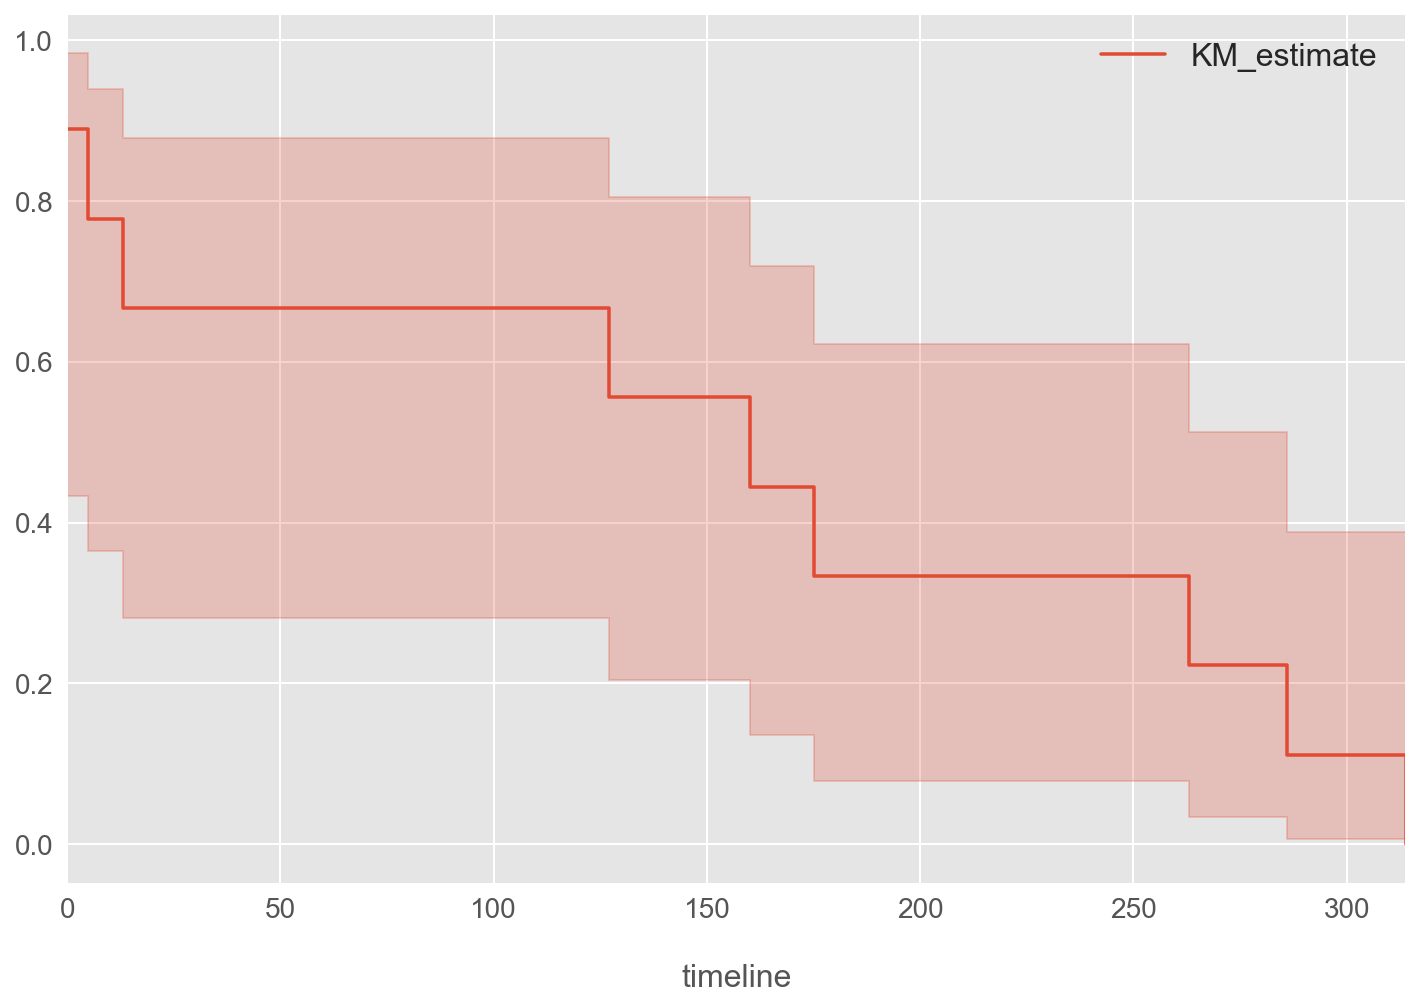

In [231]:
mask = df_regions_times2['user_id'] == 20136
graph_df = df_regions_times2[mask]
kmf.fit(graph_df['T'], event_observed=graph_df['E']).plot()

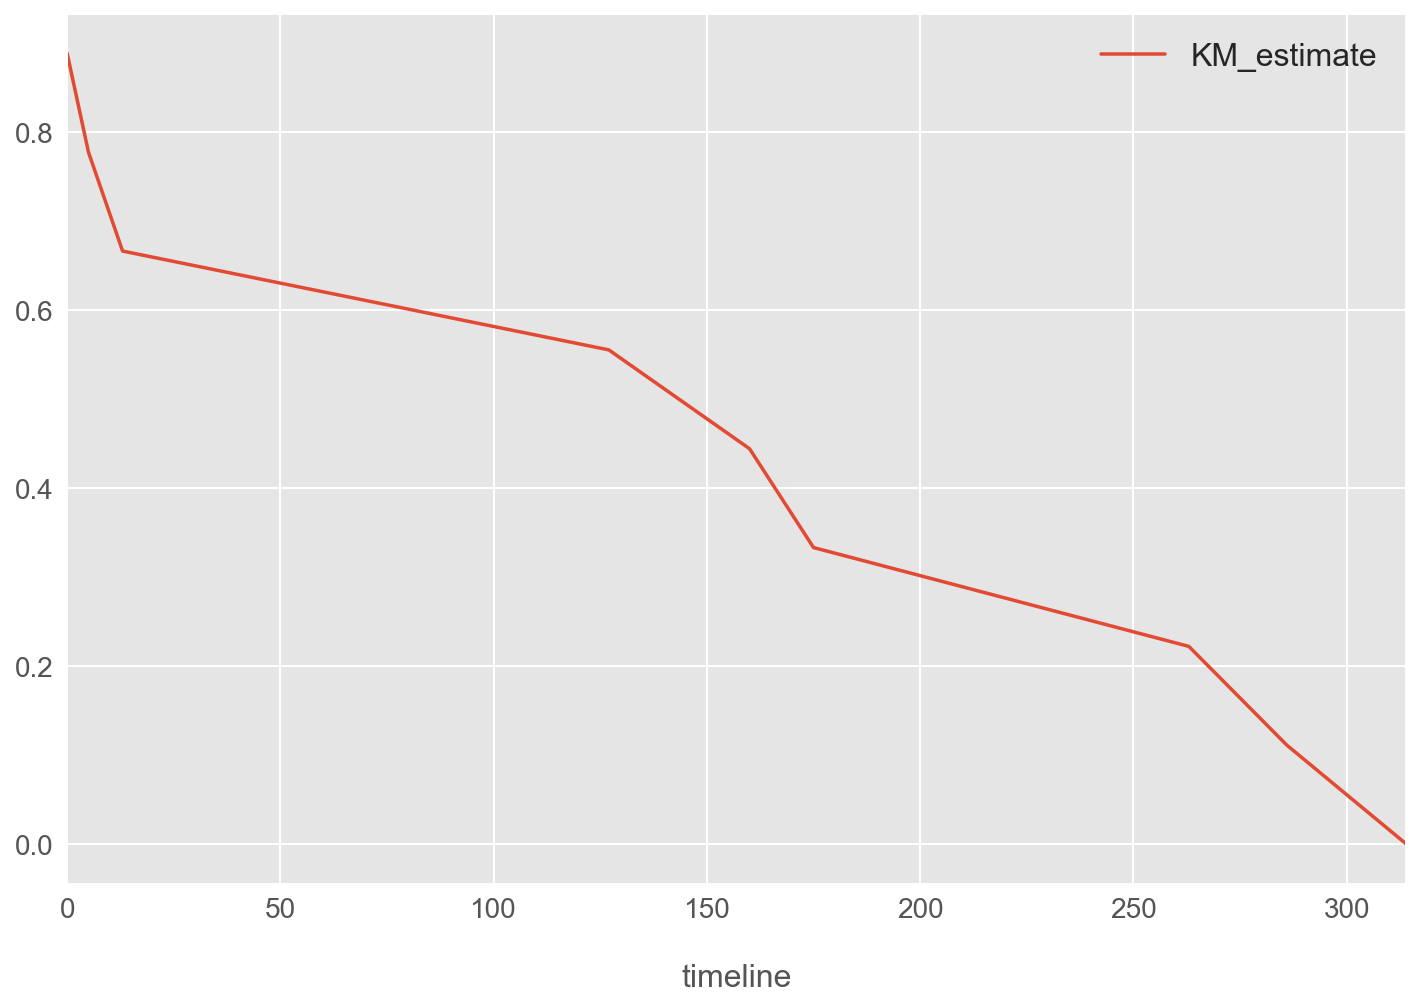

In [234]:
kmf.survival_function_.plot()

In [224]:
graph_df

,date,visits,pageviews,transactions,transactionRevenue,trafficSource,campaign,deviceType,browser,user_id,region,age,gender,T,E
18913,2016-08-17,11,61.0,NaN,NaN,google,AW - Dynamic Search Ads Whole Site,mobile,Chrome,20136,Massachusetts,under 18,male,314,1
18914,2016-09-14,3,23.0,NaN,NaN,Partners,Data Share Promo,desktop,Chrome,20136,Massachusetts,under 18,male,286,1
18915,2016-10-07,1,1.0,NaN,NaN,(direct),(not set),tablet,Safari,20136,Massachusetts,under 18,male,263,1
18916,2017-01-03,1,1.0,NaN,NaN,youtube.com,(not set),desktop,Internet Explorer,20136,Massachusetts,under 18,male,175,1
18917,2017-01-18,1,1.0,NaN,NaN,youtube.com,(not set),desktop,YaBrowser,20136,Massachusetts,under 18,male,160,1
18918,2017-02-20,1,14.0,NaN,NaN,(direct),(not set),desktop,Chrome,20136,Massachusetts,under 18,male,127,1
18919,2017-06-14,1,1.0,NaN,NaN,google,(not set),desktop,Chrome,20136,Massachusetts,under 18,male,13,1
18920,2017-06-22,1,3.0,NaN,NaN,(direct),(not set),desktop,Safari,20136,Massachusetts,under 18,male,5,1
18921,2017-06-27,1,1.0,NaN,NaN,(direct),(not set),mobile,Internet Explorer,20136,Massachusetts,under 18,male,0,1


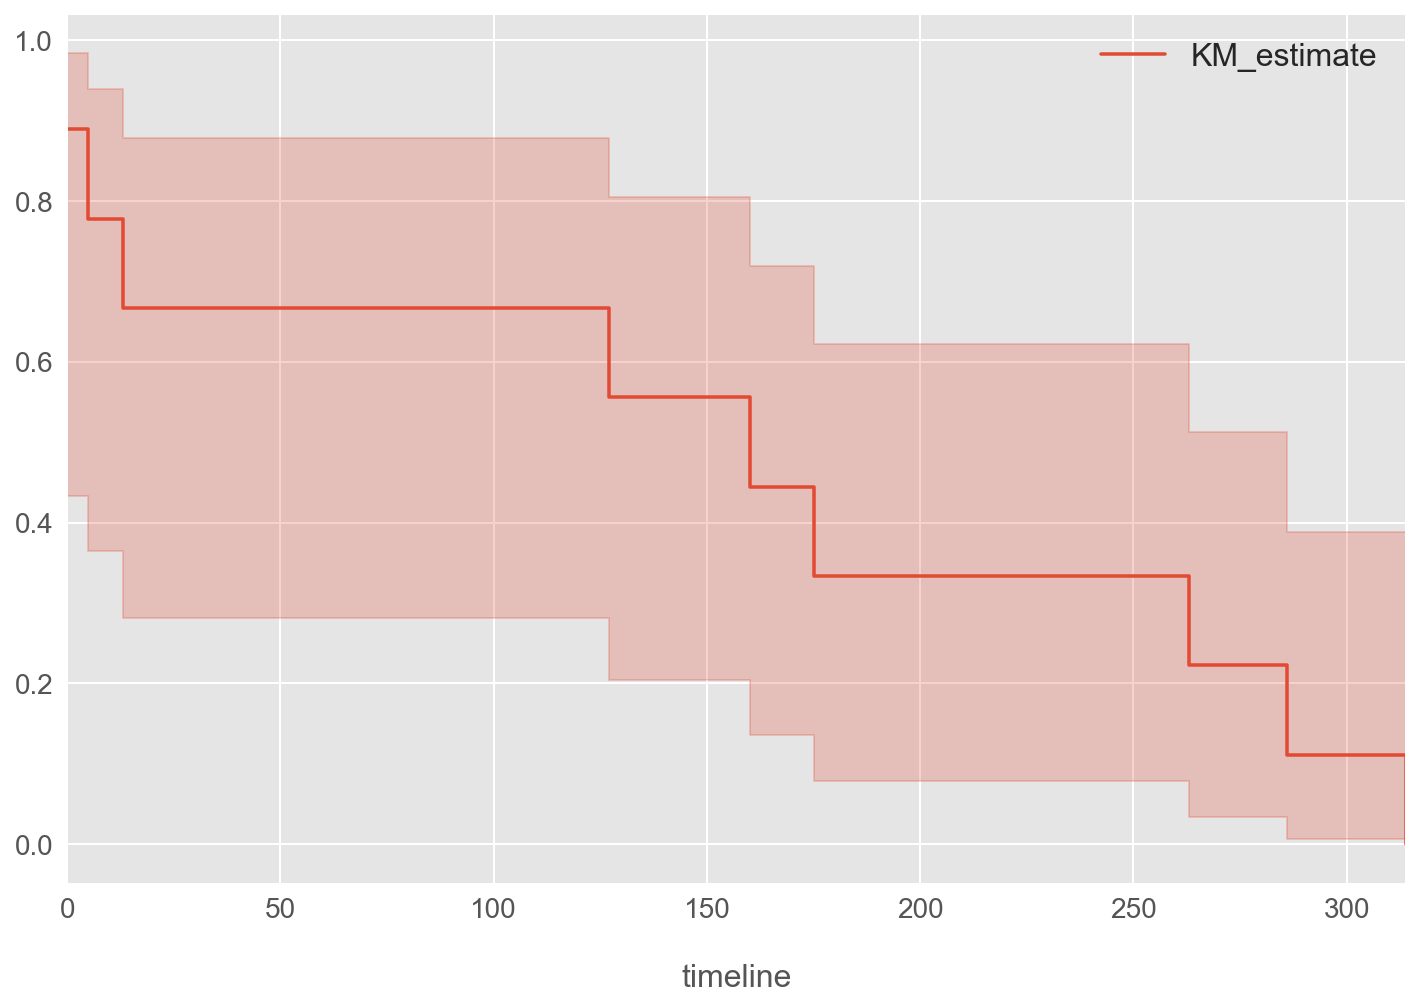

In [225]:
kmf.survival_function_
kmf.cumulative_density_
kmf.median_
kmf.plot_survival_function()

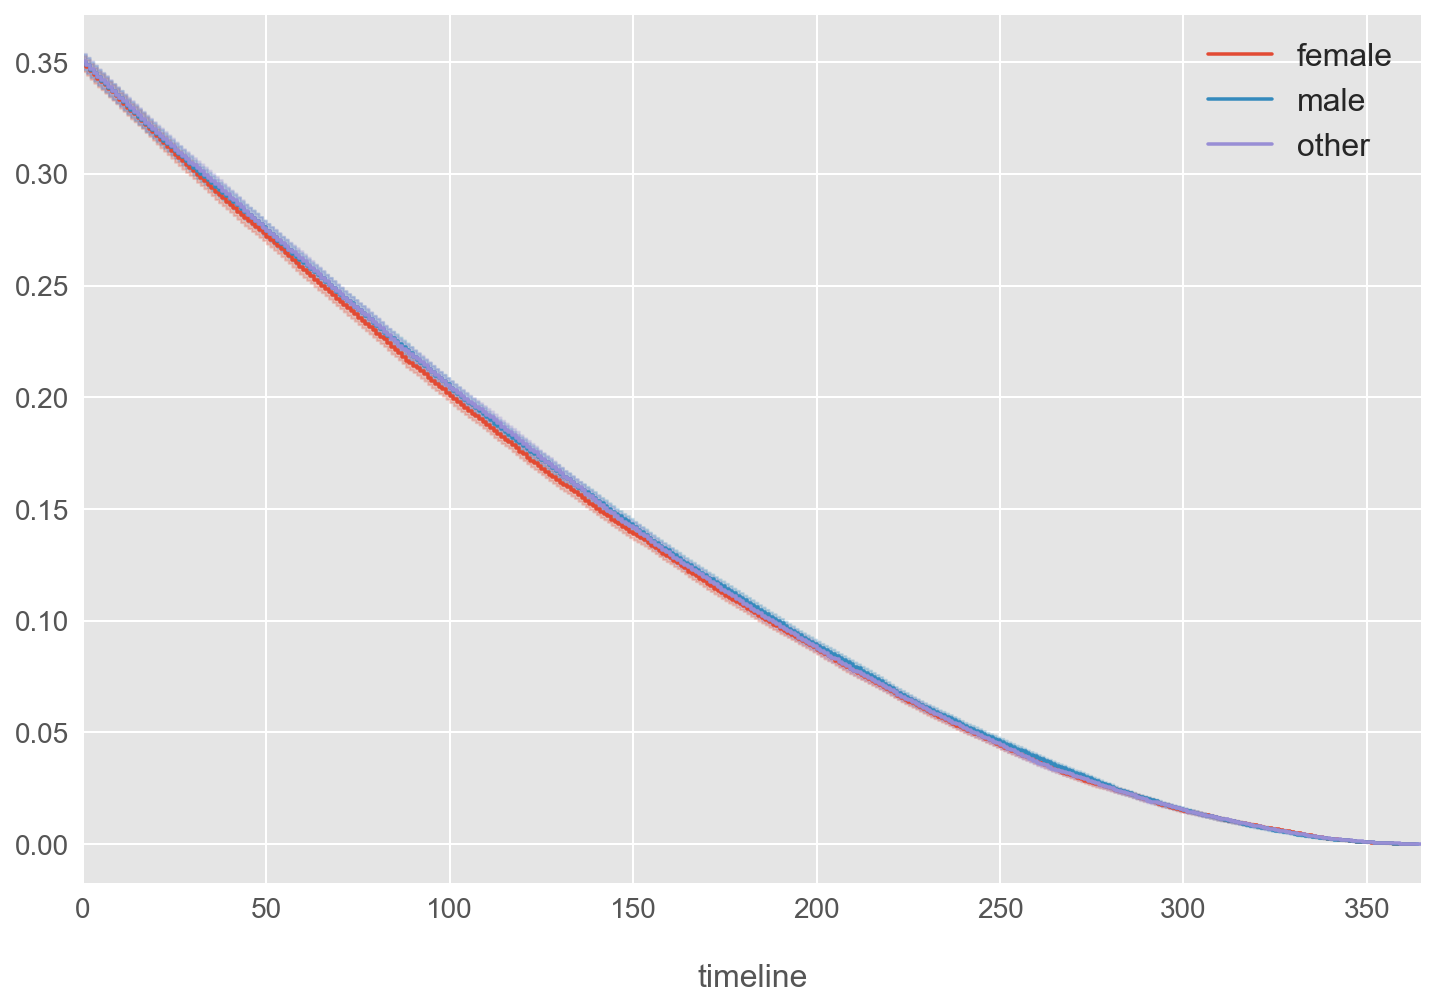

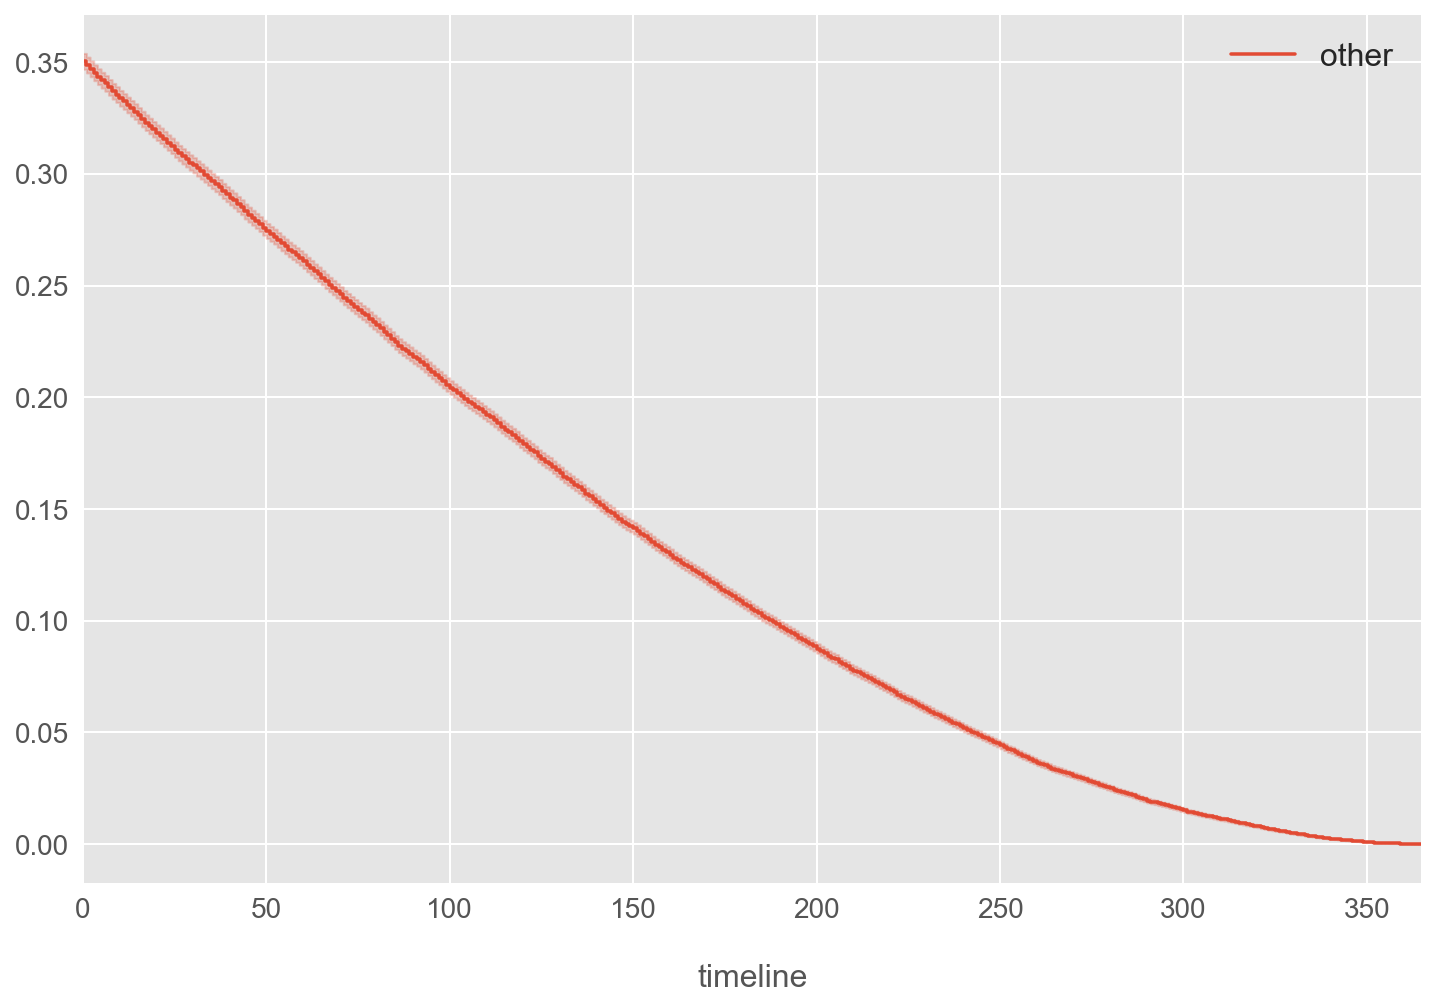

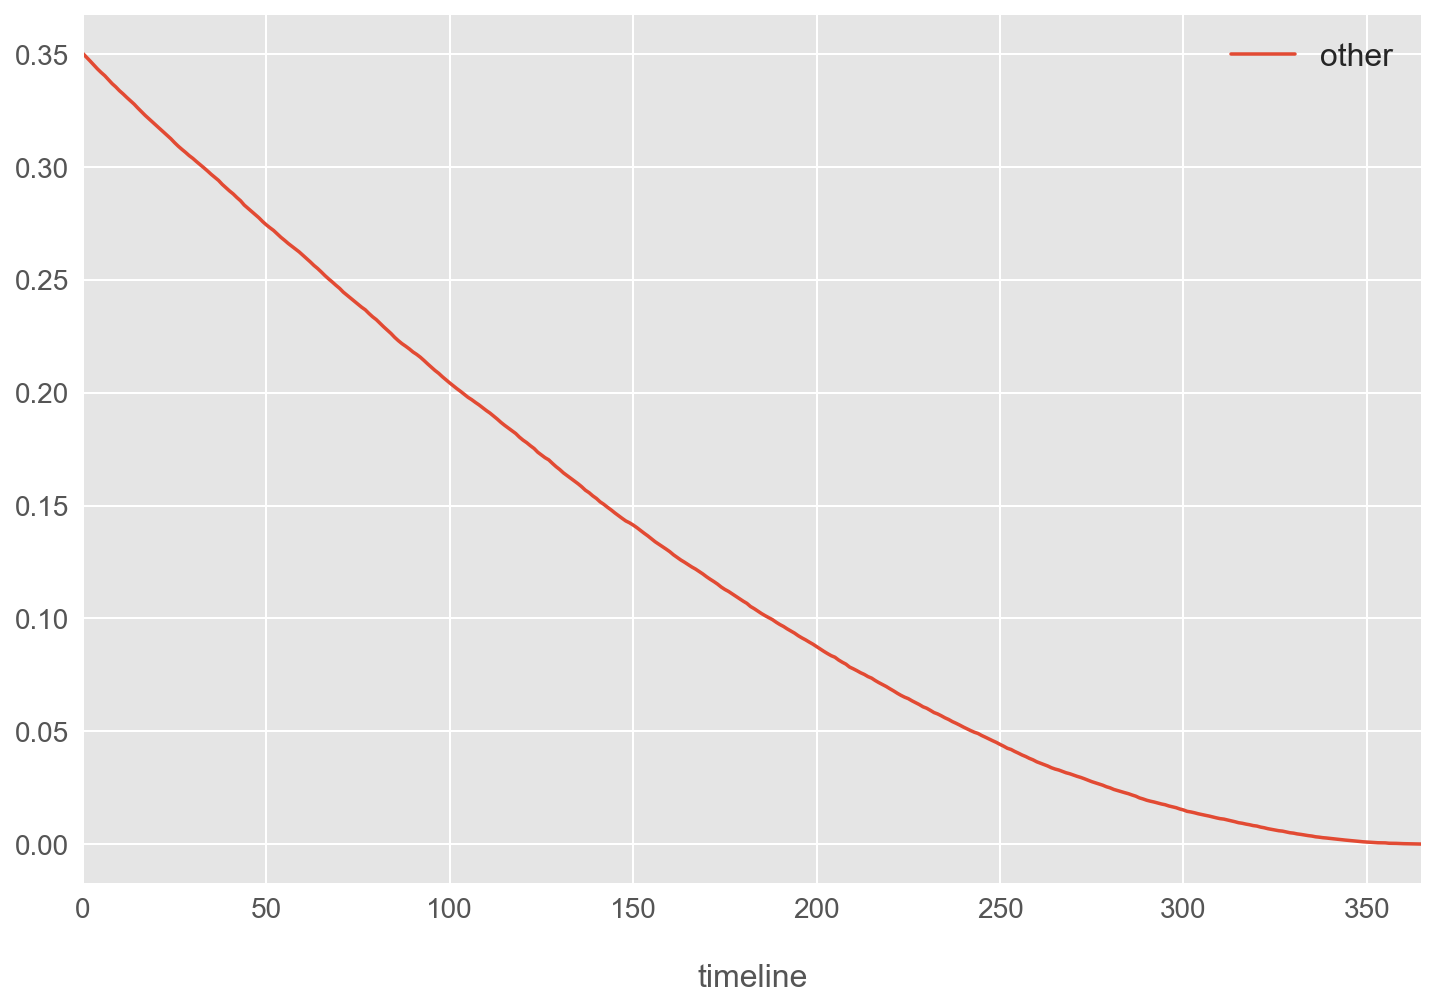

In [235]:
kmf = KaplanMeierFitter()
gender_groups = df_regions_times2['gender']
ix_m = (gender_groups == 'male')
ix_f = (gender_groups == 'female')
ix_o = (gender_groups == 'other')

kmf.fit(df_regions_times2[ix_f]['T'], df_regions_times2[ix_f]['E'], label='female')
ax = kmf.plot()

kmf = KaplanMeierFitter()

kmf.fit(df_regions_times2[ix_m]['T'], df_regions_times2[ix_m]['E'], label='male')
ax = kmf.plot(ax=ax)

kmf = KaplanMeierFitter()

kmf.fit(df_regions_times2[ix_o]['T'], df_regions_times2[ix_o]['E'], label='other')
ax = kmf.plot(ax=ax)
kmf.plot_survival_function()
kmf.survival_function_.plot()

In [154]:
df_regions_times2['age'].value_counts()

under 18    34963
over 60     34901
35-45       34858
18-25       34632
45-60       34502
25-35       34379
Name: age, dtype: int64

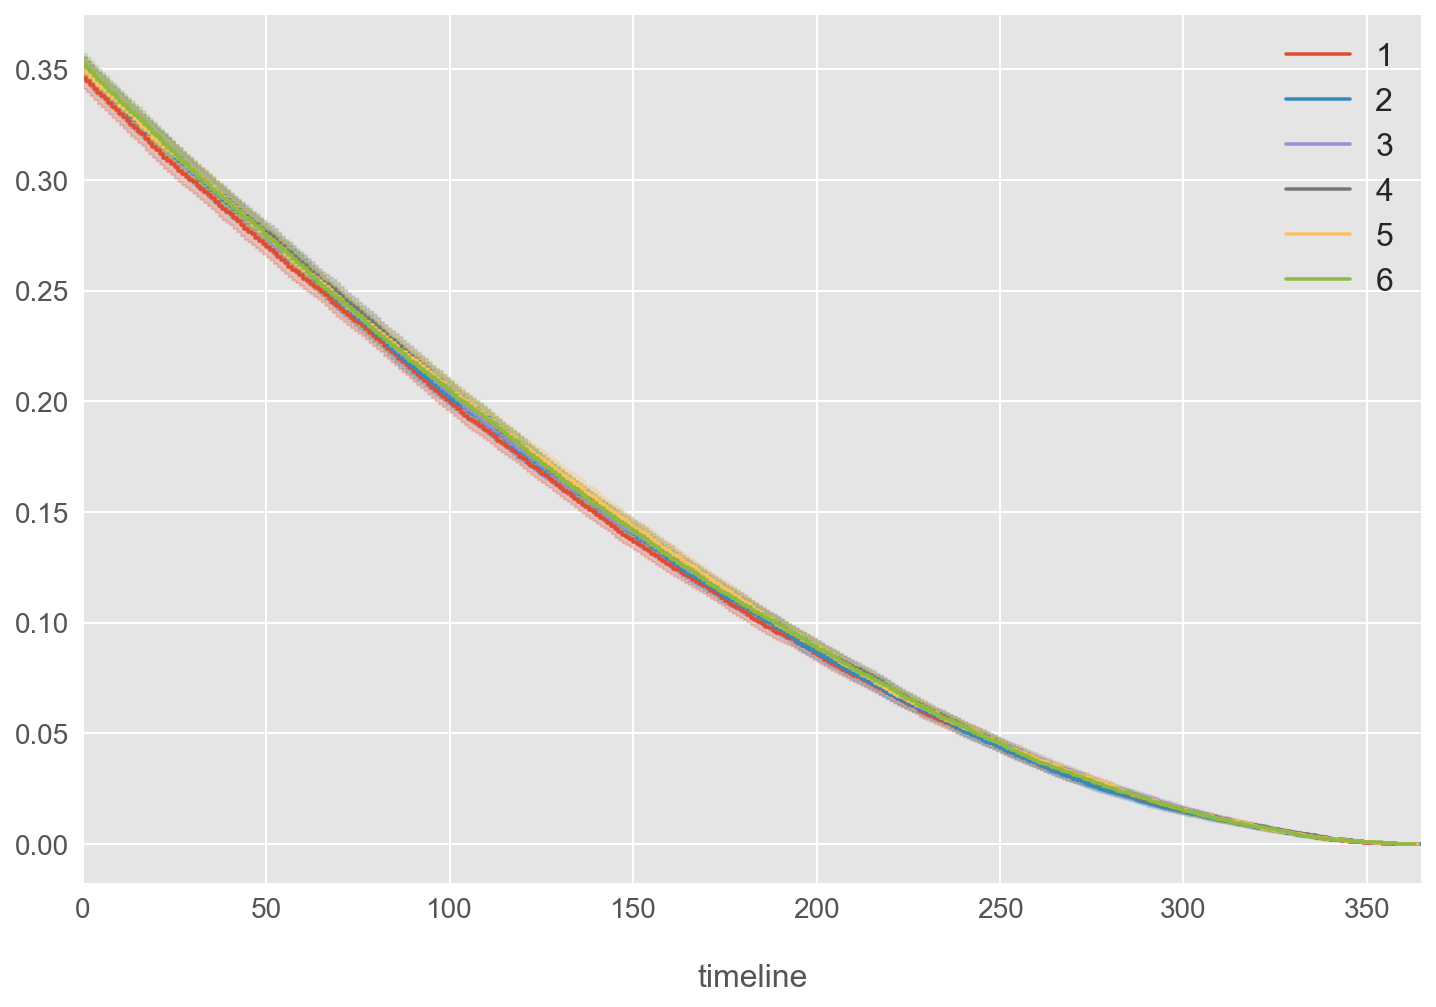

In [167]:
age_groups = df_regions_times2['age']
ix_1 = (age_groups == 'under 18')
ix_2 = (age_groups == '18-25')
ix_3 = (age_groups == '25-35')
ix_4 = (age_groups == '35-45')
ix_5 = (age_groups == '45-60')
ix_6 = (age_groups == 'over 60')


kmf.fit(df_regions_times2[ix_1]['T'], df_regions_times2[ix_1]['E'], label='1')
ax = kmf.plot()

kmf.fit(df_regions_times2[ix_2]['T'], df_regions_times2[ix_2]['E'], label='2')
ax = kmf.plot(ax=ax)

kmf.fit(df_regions_times2[ix_3]['T'], df_regions_times2[ix_3]['E'], label='3')
ax = kmf.plot(ax=ax)

kmf.fit(df_regions_times2[ix_4]['T'], df_regions_times2[ix_4]['E'], label='4')
ax = kmf.plot(ax=ax)
kmf.fit(df_regions_times2[ix_5]['T'], df_regions_times2[ix_5]['E'], label='5')
ax = kmf.plot(ax=ax)
kmf.fit(df_regions_times2[ix_6]['T'], df_regions_times2[ix_6]['E'], label='6')
ax = kmf.plot(ax=ax)


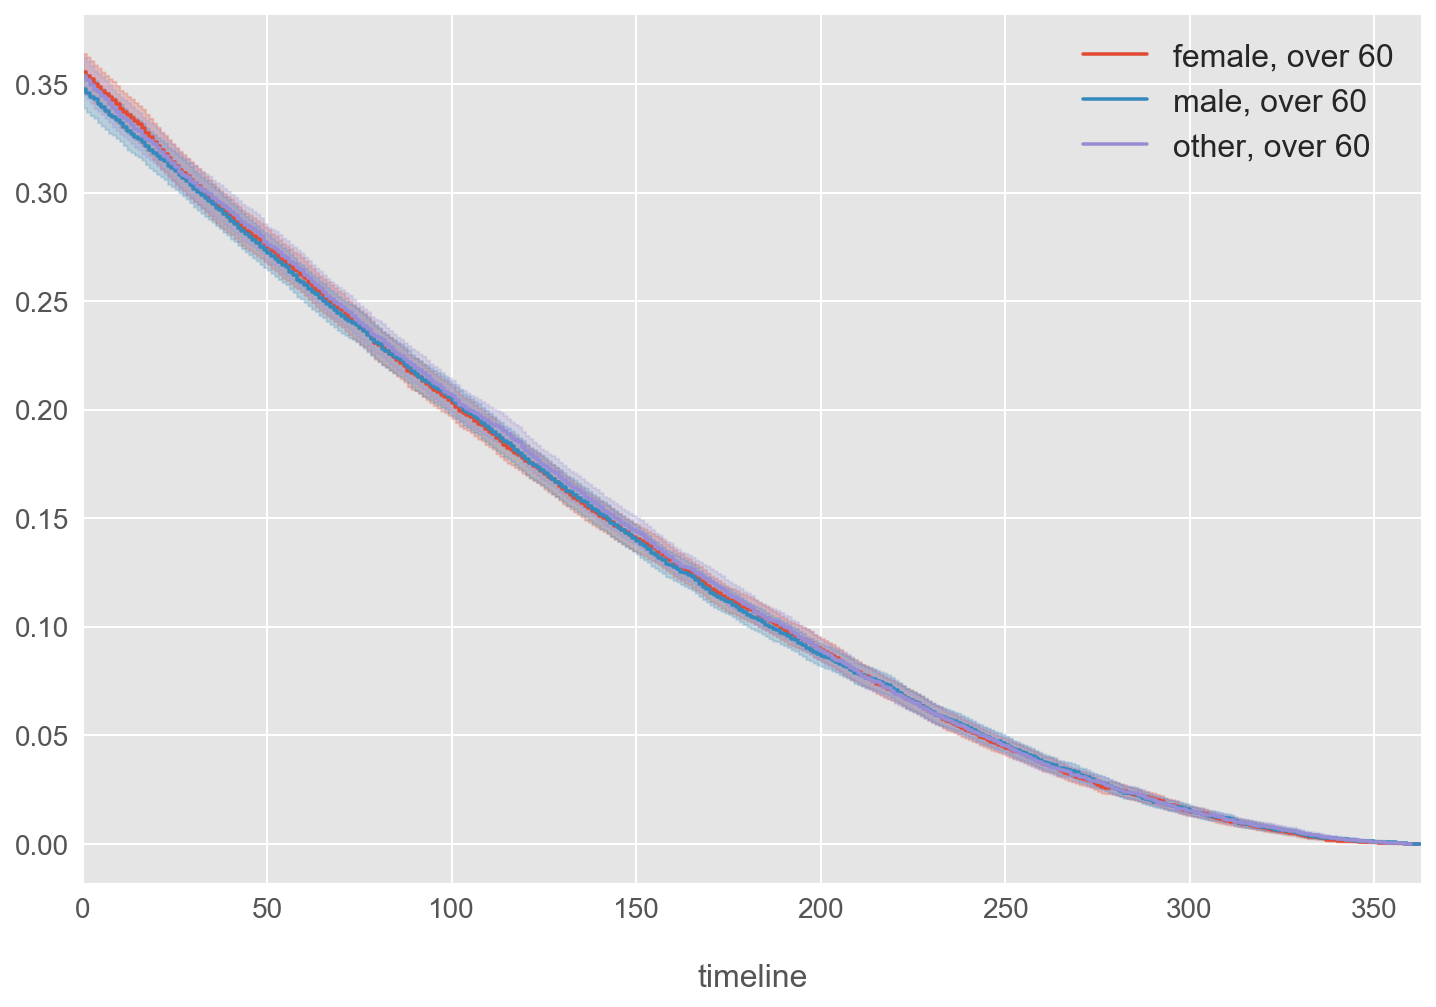

In [200]:
mask = (df_regions_times2['age'] == 'over 60') & (df_regions_times2['gender'] == 'female')
kmf.fit(df_regions_times2[mask]['T'], df_regions_times2[mask]['E'], label='female, over 60')
ax = kmf.plot()

mask2 = (df_regions_times2['age'] == 'over 60') & (df_regions_times2['gender'] == 'male')
kmf.fit(df_regions_times2[mask2]['T'], df_regions_times2[mask2]['E'], label='male, over 60')
ax = kmf.plot(ax=ax)

mask3 = (df_regions_times2['age'] == 'over 60') & (df_regions_times2['gender'] == 'other')
kmf.fit(df_regions_times2[mask3]['T'], df_regions_times2[mask3]['E'], label='other, over 60')
ax = kmf.plot(ax=ax)

## Select only one row per user
- Include time (days) since first interaction
- Include whether they survived

In [209]:
top_dfs_list = []
for user in tqdm(list(df_regions_times2['user_id'].unique())):
    mask = df_regions_times2['user_id'] == user
    masked_df = df_regions_times2[mask].reset_index(drop=True)
    mask_top = masked_df['T'] == max(masked_df['T'])
    top_df = masked_df[mask_top]
    top_dfs_list.append(top_df)
    
df_unique_users = pd.concat(top_dfs_list)



  0%|          | 0/135206 [00:00<?, ?it/s]

  0%|          | 26/135206 [00:00<08:52, 253.83it/s]

  0%|          | 51/135206 [00:00<08:56, 252.05it/s]

  0%|          | 78/135206 [00:00<08:46, 256.55it/s]

  0%|          | 103/135206 [00:00<08:52, 253.69it/s]

  0%|          | 127/135206 [00:00<09:05, 247.76it/s]

  0%|          | 152/135206 [00:00<09:10, 245.38it/s]

  0%|          | 179/135206 [00:00<08:59, 250.43it/s]

  0%|          | 208/135206 [00:00<08:37, 261.03it/s]

  0%|          | 237/135206 [00:00<08:26, 266.42it/s]

  0%|          | 263/135206 [00:01<09:28, 237.31it/s]

  0%|          | 293/135206 [00:01<08:56, 251.62it/s]

  0%|          | 321/135206 [00:01<08:39, 259.44it/s]

  0%|          | 348/135206 [00:01<08:36, 260.94it/s]

  0%|          | 375/135206 [00:01<08:34, 261.87it/s]

  0%|          | 402/135206 [00:01<08:46, 255.92it/s]

  0%|          | 433/135206 [00:01<08:20, 269.45it/s]

  0%|          | 464/135206 [00:01<08:02, 279.40it/s]

  0%|          | 493/1

  4%|▍         | 5478/135206 [00:14<09:07, 236.96it/s]

  4%|▍         | 5506/135206 [00:14<08:45, 246.97it/s]

  4%|▍         | 5535/135206 [00:15<08:25, 256.36it/s]

  4%|▍         | 5563/135206 [00:15<08:26, 255.84it/s]

  4%|▍         | 5604/135206 [00:15<07:30, 287.76it/s]

  4%|▍         | 5635/135206 [00:15<07:48, 276.49it/s]

  4%|▍         | 5665/135206 [00:15<08:29, 254.04it/s]

  4%|▍         | 5693/135206 [00:15<10:19, 209.02it/s]

  4%|▍         | 5730/135206 [00:15<09:00, 239.74it/s]

  4%|▍         | 5766/135206 [00:15<08:06, 266.32it/s]

  4%|▍         | 5804/135206 [00:16<07:23, 291.68it/s]

  4%|▍         | 5837/135206 [00:16<07:12, 299.18it/s]

  4%|▍         | 5870/135206 [00:16<07:21, 292.79it/s]

  4%|▍         | 5901/135206 [00:16<07:28, 288.28it/s]

  4%|▍         | 5931/135206 [00:16<07:55, 271.67it/s]

  4%|▍         | 5968/135206 [00:16<07:20, 293.45it/s]

  4%|▍         | 5999/135206 [00:16<07:41, 279.83it/s]

  4%|▍         | 6031/135206 [00:16<07:31, 286.4

  7%|▋         | 9892/135206 [00:30<05:43, 365.17it/s]

  7%|▋         | 9931/135206 [00:30<05:39, 369.10it/s]

  7%|▋         | 9970/135206 [00:31<05:59, 348.26it/s]

  7%|▋         | 10007/135206 [00:31<06:39, 313.09it/s]

  7%|▋         | 10040/135206 [00:31<06:58, 299.09it/s]

  7%|▋         | 10088/135206 [00:31<06:11, 336.68it/s]

  7%|▋         | 10125/135206 [00:31<06:01, 345.57it/s]

  8%|▊         | 10162/135206 [00:31<07:16, 286.34it/s]

  8%|▊         | 10194/135206 [00:31<08:05, 257.43it/s]

  8%|▊         | 10232/135206 [00:31<07:18, 284.81it/s]

  8%|▊         | 10267/135206 [00:32<06:56, 299.99it/s]

  8%|▊         | 10312/135206 [00:32<06:18, 330.26it/s]

  8%|▊         | 10353/135206 [00:32<05:56, 350.53it/s]

  8%|▊         | 10391/135206 [00:32<05:55, 351.24it/s]

  8%|▊         | 10428/135206 [00:32<07:14, 287.35it/s]

  8%|▊         | 10460/135206 [00:32<09:26, 220.27it/s]

  8%|▊         | 10487/135206 [00:32<09:41, 214.42it/s]

  8%|▊         | 10530/135206 [00:

 11%|█         | 14571/135206 [00:45<04:39, 430.97it/s]

 11%|█         | 14627/135206 [00:45<04:20, 462.63it/s]

 11%|█         | 14675/135206 [00:45<04:18, 467.10it/s]

 11%|█         | 14724/135206 [00:46<04:14, 472.99it/s]

 11%|█         | 14773/135206 [00:46<04:13, 475.90it/s]

 11%|█         | 14825/135206 [00:46<04:07, 486.60it/s]

 11%|█         | 14879/135206 [00:46<04:01, 497.95it/s]

 11%|█         | 14931/135206 [00:46<03:59, 502.49it/s]

 11%|█         | 14982/135206 [00:46<04:08, 483.84it/s]

 11%|█         | 15034/135206 [00:46<04:03, 493.12it/s]

 11%|█         | 15084/135206 [00:46<04:06, 487.25it/s]

 11%|█         | 15137/135206 [00:46<04:00, 498.86it/s]

 11%|█         | 15191/135206 [00:46<03:56, 508.16it/s]

 11%|█▏        | 15244/135206 [00:47<03:53, 513.02it/s]

 11%|█▏        | 15298/135206 [00:47<03:51, 518.54it/s]

 11%|█▏        | 15352/135206 [00:47<03:48, 523.55it/s]

 11%|█▏        | 15405/135206 [00:47<03:52, 514.79it/s]

 11%|█▏        | 15457/135206 [

 15%|█▌        | 20375/135206 [00:59<05:14, 364.78it/s]

 15%|█▌        | 20413/135206 [01:00<05:15, 364.38it/s]

 15%|█▌        | 20450/135206 [01:00<05:26, 351.38it/s]

 15%|█▌        | 20486/135206 [01:00<05:37, 340.01it/s]

 15%|█▌        | 20521/135206 [01:00<05:42, 334.72it/s]

 15%|█▌        | 20555/135206 [01:00<05:45, 331.81it/s]

 15%|█▌        | 20593/135206 [01:00<05:34, 343.11it/s]

 15%|█▌        | 20633/135206 [01:00<05:20, 357.86it/s]

 15%|█▌        | 20670/135206 [01:00<05:51, 325.89it/s]

 15%|█▌        | 20704/135206 [01:00<06:33, 291.26it/s]

 15%|█▌        | 20736/135206 [01:01<06:24, 297.63it/s]

 15%|█▌        | 20767/135206 [01:01<06:28, 294.93it/s]

 15%|█▌        | 20798/135206 [01:01<06:25, 296.40it/s]

 15%|█▌        | 20835/135206 [01:01<06:03, 314.55it/s]

 15%|█▌        | 20876/135206 [01:01<05:38, 338.11it/s]

 15%|█▌        | 20915/135206 [01:01<05:26, 350.40it/s]

 16%|█▌        | 20960/135206 [01:01<05:04, 374.91it/s]

 16%|█▌        | 20999/135206 [

 18%|█▊        | 24897/135206 [01:14<08:22, 219.36it/s]

 18%|█▊        | 24920/135206 [01:14<09:14, 198.79it/s]

 18%|█▊        | 24941/135206 [01:14<09:54, 185.35it/s]

 18%|█▊        | 24961/135206 [01:15<10:34, 173.66it/s]

 18%|█▊        | 24980/135206 [01:15<11:25, 160.86it/s]

 18%|█▊        | 24997/135206 [01:15<11:16, 162.81it/s]

 19%|█▊        | 25017/135206 [01:15<10:41, 171.88it/s]

 19%|█▊        | 25036/135206 [01:15<10:25, 176.08it/s]

 19%|█▊        | 25054/135206 [01:15<11:15, 163.08it/s]

 19%|█▊        | 25071/135206 [01:15<11:21, 161.64it/s]

 19%|█▊        | 25088/135206 [01:15<12:31, 146.57it/s]

 19%|█▊        | 25104/135206 [01:16<19:31, 94.02it/s] 

 19%|█▊        | 25132/135206 [01:16<15:39, 117.21it/s]

 19%|█▊        | 25157/135206 [01:16<13:11, 139.00it/s]

 19%|█▊        | 25181/135206 [01:16<11:38, 157.57it/s]

 19%|█▊        | 25211/135206 [01:16<10:00, 183.25it/s]

 19%|█▊        | 25235/135206 [01:16<09:49, 186.65it/s]

 19%|█▊        | 25257/135206 [

 21%|██        | 28185/135206 [01:30<07:03, 252.76it/s]

 21%|██        | 28212/135206 [01:30<07:02, 253.31it/s]

 21%|██        | 28245/135206 [01:31<06:33, 271.91it/s]

 21%|██        | 28282/135206 [01:31<06:02, 295.23it/s]

 21%|██        | 28319/135206 [01:31<05:40, 314.09it/s]

 21%|██        | 28352/135206 [01:31<06:08, 289.73it/s]

 21%|██        | 28383/135206 [01:31<06:01, 295.21it/s]

 21%|██        | 28414/135206 [01:31<05:59, 297.27it/s]

 21%|██        | 28448/135206 [01:31<05:49, 305.25it/s]

 21%|██        | 28480/135206 [01:31<06:11, 287.15it/s]

 21%|██        | 28517/135206 [01:31<05:46, 307.71it/s]

 21%|██        | 28551/135206 [01:31<05:39, 314.22it/s]

 21%|██        | 28584/135206 [01:32<05:38, 315.35it/s]

 21%|██        | 28623/135206 [01:32<05:18, 334.22it/s]

 21%|██        | 28658/135206 [01:32<05:24, 328.41it/s]

 21%|██        | 28692/135206 [01:32<05:55, 299.83it/s]

 21%|██        | 28723/135206 [01:32<05:52, 302.05it/s]

 21%|██▏       | 28757/135206 [

 25%|██▍       | 33177/135206 [01:45<06:34, 258.47it/s]

 25%|██▍       | 33204/135206 [01:45<07:56, 214.26it/s]

 25%|██▍       | 33227/135206 [01:45<08:37, 197.03it/s]

 25%|██▍       | 33264/135206 [01:45<07:27, 227.91it/s]

 25%|██▍       | 33304/135206 [01:45<06:29, 261.62it/s]

 25%|██▍       | 33340/135206 [01:45<05:58, 284.42it/s]

 25%|██▍       | 33381/135206 [01:45<05:25, 312.85it/s]

 25%|██▍       | 33420/135206 [01:46<05:06, 332.08it/s]

 25%|██▍       | 33462/135206 [01:46<04:48, 352.47it/s]

 25%|██▍       | 33500/135206 [01:46<04:59, 339.78it/s]

 25%|██▍       | 33536/135206 [01:46<05:33, 304.41it/s]

 25%|██▍       | 33569/135206 [01:46<05:45, 294.15it/s]

 25%|██▍       | 33600/135206 [01:46<08:50, 191.66it/s]

 25%|██▍       | 33625/135206 [01:47<13:03, 129.62it/s]

 25%|██▍       | 33645/135206 [01:47<17:02, 99.33it/s] 

 25%|██▍       | 33661/135206 [01:47<19:23, 87.29it/s]

 25%|██▍       | 33674/135206 [01:47<21:27, 78.83it/s]

 25%|██▍       | 33694/135206 [01

 28%|██▊       | 37364/135206 [02:01<03:50, 424.99it/s]

 28%|██▊       | 37413/135206 [02:01<03:41, 441.68it/s]

 28%|██▊       | 37462/135206 [02:01<03:35, 454.56it/s]

 28%|██▊       | 37508/135206 [02:01<03:41, 440.72it/s]

 28%|██▊       | 37554/135206 [02:01<03:39, 445.72it/s]

 28%|██▊       | 37599/135206 [02:01<03:38, 445.74it/s]

 28%|██▊       | 37644/135206 [02:02<03:47, 428.82it/s]

 28%|██▊       | 37690/135206 [02:02<03:43, 436.08it/s]

 28%|██▊       | 37740/135206 [02:02<03:35, 451.51it/s]

 28%|██▊       | 37787/135206 [02:02<03:33, 456.26it/s]

 28%|██▊       | 37833/135206 [02:02<03:42, 438.51it/s]

 28%|██▊       | 37878/135206 [02:02<03:43, 434.70it/s]

 28%|██▊       | 37922/135206 [02:02<03:46, 430.33it/s]

 28%|██▊       | 37968/135206 [02:02<03:42, 437.87it/s]

 28%|██▊       | 38016/135206 [02:02<03:36, 449.54it/s]

 28%|██▊       | 38062/135206 [02:02<03:35, 451.28it/s]

 28%|██▊       | 38108/135206 [02:03<03:36, 449.02it/s]

 28%|██▊       | 38156/135206 [

 32%|███▏      | 42788/135206 [02:15<03:17, 467.61it/s]

 32%|███▏      | 42835/135206 [02:15<03:23, 454.59it/s]

 32%|███▏      | 42884/135206 [02:15<03:18, 464.00it/s]

 32%|███▏      | 42931/135206 [02:16<03:18, 463.78it/s]

 32%|███▏      | 42981/135206 [02:16<03:15, 472.06it/s]

 32%|███▏      | 43032/135206 [02:16<03:11, 481.28it/s]

 32%|███▏      | 43081/135206 [02:16<03:16, 468.17it/s]

 32%|███▏      | 43129/135206 [02:16<03:15, 470.45it/s]

 32%|███▏      | 43179/135206 [02:16<03:12, 477.13it/s]

 32%|███▏      | 43229/135206 [02:16<03:10, 483.73it/s]

 32%|███▏      | 43278/135206 [02:16<03:09, 485.16it/s]

 32%|███▏      | 43327/135206 [02:16<03:09, 484.82it/s]

 32%|███▏      | 43376/135206 [02:17<03:13, 473.40it/s]

 32%|███▏      | 43424/135206 [02:17<03:14, 472.61it/s]

 32%|███▏      | 43472/135206 [02:17<03:15, 470.26it/s]

 32%|███▏      | 43520/135206 [02:17<03:20, 456.62it/s]

 32%|███▏      | 43566/135206 [02:17<03:23, 451.13it/s]

 32%|███▏      | 43613/135206 [

 36%|███▌      | 48123/135206 [02:30<03:00, 481.51it/s]

 36%|███▌      | 48174/135206 [02:30<02:57, 488.98it/s]

 36%|███▌      | 48224/135206 [02:30<02:59, 483.66it/s]

 36%|███▌      | 48273/135206 [02:30<02:59, 485.10it/s]

 36%|███▌      | 48322/135206 [02:30<03:03, 472.95it/s]

 36%|███▌      | 48370/135206 [02:30<03:06, 464.49it/s]

 36%|███▌      | 48419/135206 [02:30<03:04, 469.34it/s]

 36%|███▌      | 48467/135206 [02:30<03:04, 471.13it/s]

 36%|███▌      | 48515/135206 [02:31<03:12, 449.28it/s]

 36%|███▌      | 48561/135206 [02:31<03:12, 449.33it/s]

 36%|███▌      | 48607/135206 [02:31<03:17, 439.27it/s]

 36%|███▌      | 48658/135206 [02:31<03:09, 456.72it/s]

 36%|███▌      | 48711/135206 [02:31<03:02, 474.80it/s]

 36%|███▌      | 48760/135206 [02:31<03:00, 478.28it/s]

 36%|███▌      | 48813/135206 [02:31<02:56, 488.96it/s]

 36%|███▌      | 48864/135206 [02:31<02:54, 494.39it/s]

 36%|███▌      | 48914/135206 [02:31<02:55, 492.93it/s]

 36%|███▌      | 48965/135206 [

 40%|████      | 54648/135206 [02:44<02:54, 461.02it/s]

 40%|████      | 54702/135206 [02:44<02:47, 480.03it/s]

 40%|████      | 54751/135206 [02:44<02:49, 474.37it/s]

 41%|████      | 54799/135206 [02:44<02:54, 461.58it/s]

 41%|████      | 54848/135206 [02:44<02:51, 467.84it/s]

 41%|████      | 54896/135206 [02:44<03:00, 445.48it/s]

 41%|████      | 54949/135206 [02:44<02:52, 465.71it/s]

 41%|████      | 55000/135206 [02:45<02:48, 476.39it/s]

 41%|████      | 55054/135206 [02:45<02:42, 492.29it/s]

 41%|████      | 55106/135206 [02:45<02:40, 499.92it/s]

 41%|████      | 55162/135206 [02:45<02:35, 515.04it/s]

 41%|████      | 55214/135206 [02:45<02:36, 510.41it/s]

 41%|████      | 55270/135206 [02:45<02:32, 523.20it/s]

 41%|████      | 55324/135206 [02:45<02:31, 526.28it/s]

 41%|████      | 55379/135206 [02:45<02:29, 532.99it/s]

 41%|████      | 55433/135206 [02:45<02:29, 532.38it/s]

 41%|████      | 55487/135206 [02:45<02:30, 527.94it/s]

 41%|████      | 55540/135206 [

 45%|████▌     | 60922/135206 [02:59<07:38, 162.00it/s]

 45%|████▌     | 60942/135206 [02:59<07:48, 158.48it/s]

 45%|████▌     | 60964/135206 [02:59<07:10, 172.43it/s]

 45%|████▌     | 60993/135206 [02:59<06:18, 196.10it/s]

 45%|████▌     | 61034/135206 [02:59<05:20, 231.45it/s]

 45%|████▌     | 61069/135206 [02:59<04:49, 255.71it/s]

 45%|████▌     | 61100/135206 [02:59<04:34, 269.59it/s]

 45%|████▌     | 61138/135206 [02:59<04:11, 293.95it/s]

 45%|████▌     | 61183/135206 [02:59<03:46, 326.98it/s]

 45%|████▌     | 61219/135206 [03:00<04:02, 305.41it/s]

 45%|████▌     | 61252/135206 [03:00<04:12, 293.23it/s]

 45%|████▌     | 61290/135206 [03:00<03:54, 314.55it/s]

 45%|████▌     | 61331/135206 [03:00<03:38, 337.92it/s]

 45%|████▌     | 61375/135206 [03:00<03:24, 361.77it/s]

 45%|████▌     | 61414/135206 [03:00<03:20, 368.16it/s]

 45%|████▌     | 61457/135206 [03:00<03:12, 383.82it/s]

 45%|████▌     | 61502/135206 [03:00<03:03, 400.91it/s]

 46%|████▌     | 61544/135206 [

 49%|████▉     | 66705/135206 [03:13<02:55, 389.25it/s]

 49%|████▉     | 66746/135206 [03:13<03:03, 372.73it/s]

 49%|████▉     | 66785/135206 [03:13<03:05, 368.00it/s]

 49%|████▉     | 66823/135206 [03:13<03:36, 315.57it/s]

 49%|████▉     | 66857/135206 [03:14<03:36, 315.64it/s]

 49%|████▉     | 66899/135206 [03:14<03:22, 337.58it/s]

 50%|████▉     | 66945/135206 [03:14<03:06, 365.09it/s]

 50%|████▉     | 66985/135206 [03:14<03:03, 371.78it/s]

 50%|████▉     | 67024/135206 [03:14<03:12, 353.93it/s]

 50%|████▉     | 67068/135206 [03:14<03:01, 375.63it/s]

 50%|████▉     | 67111/135206 [03:14<02:54, 389.61it/s]

 50%|████▉     | 67155/135206 [03:14<02:48, 402.69it/s]

 50%|████▉     | 67196/135206 [03:14<02:48, 404.17it/s]

 50%|████▉     | 67237/135206 [03:14<02:48, 404.01it/s]

 50%|████▉     | 67283/135206 [03:15<02:42, 418.10it/s]

 50%|████▉     | 67328/135206 [03:15<02:41, 419.90it/s]

 50%|████▉     | 67372/135206 [03:15<02:39, 424.29it/s]

 50%|████▉     | 67415/135206 [

 53%|█████▎    | 72281/135206 [03:28<02:51, 367.20it/s]

 53%|█████▎    | 72320/135206 [03:28<02:57, 353.41it/s]

 54%|█████▎    | 72359/135206 [03:28<02:53, 362.65it/s]

 54%|█████▎    | 72397/135206 [03:28<02:51, 367.29it/s]

 54%|█████▎    | 72448/135206 [03:28<02:37, 399.42it/s]

 54%|█████▎    | 72501/135206 [03:29<02:26, 428.81it/s]

 54%|█████▎    | 72549/135206 [03:29<02:21, 441.84it/s]

 54%|█████▎    | 72595/135206 [03:29<02:29, 417.89it/s]

 54%|█████▎    | 72638/135206 [03:29<02:59, 348.40it/s]

 54%|█████▍    | 72683/135206 [03:29<02:47, 372.24it/s]

 54%|█████▍    | 72731/135206 [03:29<02:36, 398.23it/s]

 54%|█████▍    | 72782/135206 [03:29<02:26, 426.17it/s]

 54%|█████▍    | 72836/135206 [03:29<02:17, 453.07it/s]

 54%|█████▍    | 72884/135206 [03:29<02:15, 459.32it/s]

 54%|█████▍    | 72934/135206 [03:30<02:12, 469.40it/s]

 54%|█████▍    | 72987/135206 [03:30<02:08, 485.45it/s]

 54%|█████▍    | 73041/135206 [03:30<02:04, 500.04it/s]

 54%|█████▍    | 73092/135206 [

 58%|█████▊    | 78442/135206 [03:43<02:18, 409.70it/s]

 58%|█████▊    | 78484/135206 [03:43<02:22, 398.16it/s]

 58%|█████▊    | 78525/135206 [03:43<02:22, 396.42it/s]

 58%|█████▊    | 78566/135206 [03:43<02:22, 398.76it/s]

 58%|█████▊    | 78610/135206 [03:43<02:18, 408.60it/s]

 58%|█████▊    | 78652/135206 [03:43<02:19, 404.07it/s]

 58%|█████▊    | 78694/135206 [03:43<02:18, 407.97it/s]

 58%|█████▊    | 78735/135206 [03:43<02:19, 405.64it/s]

 58%|█████▊    | 78777/135206 [03:43<02:18, 406.35it/s]

 58%|█████▊    | 78824/135206 [03:44<02:13, 423.11it/s]

 58%|█████▊    | 78871/135206 [03:44<02:09, 434.63it/s]

 58%|█████▊    | 78916/135206 [03:44<02:08, 439.06it/s]

 58%|█████▊    | 78961/135206 [03:44<02:07, 441.62it/s]

 58%|█████▊    | 79006/135206 [03:44<02:44, 341.94it/s]

 58%|█████▊    | 79044/135206 [03:44<02:46, 336.36it/s]

 58%|█████▊    | 79088/135206 [03:44<02:35, 360.94it/s]

 59%|█████▊    | 79137/135206 [03:44<02:23, 390.84it/s]

 59%|█████▊    | 79189/135206 [

 62%|██████▏   | 84078/135206 [03:58<02:00, 424.41it/s]

 62%|██████▏   | 84122/135206 [03:58<02:32, 334.07it/s]

 62%|██████▏   | 84160/135206 [03:58<02:41, 316.74it/s]

 62%|██████▏   | 84197/135206 [03:58<02:34, 330.18it/s]

 62%|██████▏   | 84245/135206 [03:58<02:20, 362.92it/s]

 62%|██████▏   | 84290/135206 [03:58<02:12, 384.12it/s]

 62%|██████▏   | 84337/135206 [03:58<02:05, 404.34it/s]

 62%|██████▏   | 84380/135206 [03:58<02:04, 407.54it/s]

 62%|██████▏   | 84432/135206 [03:59<01:56, 434.76it/s]

 62%|██████▏   | 84480/135206 [03:59<01:53, 446.27it/s]

 63%|██████▎   | 84530/135206 [03:59<01:50, 458.21it/s]

 63%|██████▎   | 84580/135206 [03:59<01:48, 468.30it/s]

 63%|██████▎   | 84629/135206 [03:59<01:46, 473.45it/s]

 63%|██████▎   | 84677/135206 [03:59<01:47, 468.35it/s]

 63%|██████▎   | 84725/135206 [03:59<02:00, 417.20it/s]

 63%|██████▎   | 84768/135206 [03:59<02:18, 364.90it/s]

 63%|██████▎   | 84807/135206 [03:59<02:20, 357.88it/s]

 63%|██████▎   | 84850/135206 [

 66%|██████▌   | 89355/135206 [04:25<3:04:38,  4.14it/s]

 66%|██████▌   | 89355/135206 [04:25<3:04:38,  4.14it/s]

 66%|██████▌   | 89377/135206 [04:25<2:10:13,  5.87it/s]

 66%|██████▌   | 89406/135206 [04:25<1:31:53,  8.31it/s]

 66%|██████▌   | 89433/135206 [04:25<1:05:08, 11.71it/s]

 66%|██████▌   | 89465/135206 [04:25<46:17, 16.47it/s]  

 66%|██████▌   | 89499/135206 [04:25<33:03, 23.05it/s]

 66%|██████▌   | 89536/135206 [04:26<23:44, 32.05it/s]

 66%|██████▋   | 89577/135206 [04:26<17:10, 44.28it/s]

 66%|██████▋   | 89614/135206 [04:26<12:37, 60.17it/s]

 66%|██████▋   | 89648/135206 [04:26<09:34, 79.34it/s]

 66%|██████▋   | 89681/135206 [04:26<07:27, 101.65it/s]

 66%|██████▋   | 89713/135206 [04:26<05:55, 127.79it/s]

 66%|██████▋   | 89745/135206 [04:26<04:52, 155.67it/s]

 66%|██████▋   | 89778/135206 [04:26<04:06, 184.08it/s]

 66%|██████▋   | 89810/135206 [04:26<03:36, 209.89it/s]

 66%|██████▋   | 89846/135206 [04:27<03:10, 238.57it/s]

 66%|██████▋   | 89880/135206 

 70%|██████▉   | 94415/135206 [04:39<01:40, 405.86it/s]

 70%|██████▉   | 94457/135206 [04:39<01:41, 401.83it/s]

 70%|██████▉   | 94498/135206 [04:39<01:49, 371.68it/s]

 70%|██████▉   | 94537/135206 [04:39<01:51, 366.21it/s]

 70%|██████▉   | 94575/135206 [04:40<01:59, 340.33it/s]

 70%|██████▉   | 94613/135206 [04:40<01:55, 350.06it/s]

 70%|███████   | 94649/135206 [04:40<01:59, 338.19it/s]

 70%|███████   | 94689/135206 [04:40<01:54, 353.23it/s]

 70%|███████   | 94732/135206 [04:40<01:48, 371.47it/s]

 70%|███████   | 94770/135206 [04:40<01:53, 357.02it/s]

 70%|███████   | 94820/135206 [04:40<01:43, 390.33it/s]

 70%|███████   | 94861/135206 [04:40<01:43, 389.49it/s]

 70%|███████   | 94911/135206 [04:40<01:36, 416.53it/s]

 70%|███████   | 94961/135206 [04:40<01:31, 438.35it/s]

 70%|███████   | 95011/135206 [04:41<01:28, 454.68it/s]

 70%|███████   | 95063/135206 [04:41<01:25, 472.24it/s]

 70%|███████   | 95116/135206 [04:41<01:22, 486.65it/s]

 70%|███████   | 95166/135206 [

 74%|███████▍  | 100471/135206 [04:53<01:18, 440.56it/s]

 74%|███████▍  | 100521/135206 [04:53<01:16, 455.19it/s]

 74%|███████▍  | 100570/135206 [04:53<01:14, 462.57it/s]

 74%|███████▍  | 100617/135206 [04:53<01:14, 463.57it/s]

 74%|███████▍  | 100667/135206 [04:53<01:13, 472.29it/s]

 74%|███████▍  | 100716/135206 [04:54<01:12, 476.80it/s]

 75%|███████▍  | 100764/135206 [04:54<01:13, 469.89it/s]

 75%|███████▍  | 100813/135206 [04:54<01:12, 475.59it/s]

 75%|███████▍  | 100864/135206 [04:54<01:10, 485.23it/s]

 75%|███████▍  | 100914/135206 [04:54<01:10, 489.24it/s]

 75%|███████▍  | 100964/135206 [04:54<01:14, 458.95it/s]

 75%|███████▍  | 101011/135206 [04:54<01:24, 406.84it/s]

 75%|███████▍  | 101054/135206 [04:54<01:24, 404.49it/s]

 75%|███████▍  | 101099/135206 [04:54<01:21, 416.83it/s]

 75%|███████▍  | 101147/135206 [04:55<01:18, 433.48it/s]

 75%|███████▍  | 101199/135206 [04:55<01:14, 454.34it/s]

 75%|███████▍  | 101247/135206 [04:55<01:13, 461.05it/s]

 75%|███████▍ 

 78%|███████▊  | 105828/135206 [05:07<01:07, 435.93it/s]

 78%|███████▊  | 105872/135206 [05:07<01:10, 414.73it/s]

 78%|███████▊  | 105914/135206 [05:07<01:10, 413.84it/s]

 78%|███████▊  | 105956/135206 [05:07<01:11, 408.39it/s]

 78%|███████▊  | 105998/135206 [05:07<01:11, 408.71it/s]

 78%|███████▊  | 106045/135206 [05:08<01:08, 423.86it/s]

 78%|███████▊  | 106088/135206 [05:08<01:13, 396.53it/s]

 78%|███████▊  | 106132/135206 [05:08<01:11, 407.24it/s]

 79%|███████▊  | 106174/135206 [05:08<01:12, 398.52it/s]

 79%|███████▊  | 106215/135206 [05:08<01:13, 395.83it/s]

 79%|███████▊  | 106259/135206 [05:08<01:11, 407.68it/s]

 79%|███████▊  | 106301/135206 [05:08<01:10, 410.33it/s]

 79%|███████▊  | 106345/135206 [05:08<01:09, 415.79it/s]

 79%|███████▊  | 106387/135206 [05:08<01:15, 380.59it/s]

 79%|███████▊  | 106426/135206 [05:09<01:21, 354.42it/s]

 79%|███████▊  | 106463/135206 [05:09<01:24, 341.91it/s]

 79%|███████▉  | 106510/135206 [05:09<01:17, 370.66it/s]

 79%|███████▉ 

 82%|████████▏ | 111408/135206 [05:21<00:50, 473.37it/s]

 82%|████████▏ | 111456/135206 [05:21<00:52, 450.33it/s]

 82%|████████▏ | 111502/135206 [05:21<00:55, 430.59it/s]

 83%|████████▎ | 111546/135206 [05:21<00:56, 419.41it/s]

 83%|████████▎ | 111591/135206 [05:21<00:55, 426.15it/s]

 83%|████████▎ | 111641/135206 [05:22<00:52, 445.39it/s]

 83%|████████▎ | 111691/135206 [05:22<00:51, 458.86it/s]

 83%|████████▎ | 111738/135206 [05:22<00:51, 459.80it/s]

 83%|████████▎ | 111785/135206 [05:22<00:53, 438.12it/s]

 83%|████████▎ | 111830/135206 [05:22<00:53, 436.42it/s]

 83%|████████▎ | 111876/135206 [05:22<00:52, 441.82it/s]

 83%|████████▎ | 111921/135206 [05:22<00:52, 444.20it/s]

 83%|████████▎ | 111970/135206 [05:22<00:51, 455.04it/s]

 83%|████████▎ | 112022/135206 [05:22<00:49, 471.54it/s]

 83%|████████▎ | 112073/135206 [05:22<00:48, 480.84it/s]

 83%|████████▎ | 112122/135206 [05:23<00:48, 480.75it/s]

 83%|████████▎ | 112171/135206 [05:23<00:48, 474.40it/s]

 83%|████████▎

 87%|████████▋ | 117521/135206 [05:35<01:17, 227.16it/s]

 87%|████████▋ | 117547/135206 [05:35<01:22, 214.72it/s]

 87%|████████▋ | 117571/135206 [05:35<01:23, 211.80it/s]

 87%|████████▋ | 117604/135206 [05:35<01:14, 235.41it/s]

 87%|████████▋ | 117641/135206 [05:35<01:06, 263.85it/s]

 87%|████████▋ | 117683/135206 [05:35<00:59, 296.90it/s]

 87%|████████▋ | 117723/135206 [05:35<00:54, 321.68it/s]

 87%|████████▋ | 117767/135206 [05:36<00:50, 348.58it/s]

 87%|████████▋ | 117812/135206 [05:36<00:46, 372.91it/s]

 87%|████████▋ | 117856/135206 [05:36<00:44, 389.40it/s]

 87%|████████▋ | 117902/135206 [05:36<00:42, 407.02it/s]

 87%|████████▋ | 117945/135206 [05:36<00:41, 412.58it/s]

 87%|████████▋ | 117990/135206 [05:36<00:40, 420.90it/s]

 87%|████████▋ | 118037/135206 [05:36<00:39, 432.83it/s]

 87%|████████▋ | 118083/135206 [05:36<00:38, 440.27it/s]

 87%|████████▋ | 118128/135206 [05:36<00:38, 440.67it/s]

 87%|████████▋ | 118175/135206 [05:36<00:37, 448.32it/s]

 87%|████████▋

 91%|█████████ | 123215/135206 [05:49<00:34, 349.93it/s]

 91%|█████████ | 123252/135206 [05:49<00:36, 330.41it/s]

 91%|█████████ | 123295/135206 [05:49<00:33, 353.47it/s]

 91%|█████████ | 123333/135206 [05:49<00:32, 360.71it/s]

 91%|█████████ | 123372/135206 [05:49<00:32, 366.27it/s]

 91%|█████████▏| 123410/135206 [05:49<00:32, 359.35it/s]

 91%|█████████▏| 123450/135206 [05:49<00:32, 367.37it/s]

 91%|█████████▏| 123488/135206 [05:49<00:33, 353.83it/s]

 91%|█████████▏| 123524/135206 [05:50<00:34, 341.38it/s]

 91%|█████████▏| 123559/135206 [05:50<00:34, 338.90it/s]

 91%|█████████▏| 123603/135206 [05:50<00:31, 363.02it/s]

 91%|█████████▏| 123640/135206 [05:50<00:37, 308.60it/s]

 91%|█████████▏| 123683/135206 [05:50<00:34, 337.02it/s]

 92%|█████████▏| 123724/135206 [05:50<00:32, 353.95it/s]

 92%|█████████▏| 123762/135206 [05:50<00:32, 348.17it/s]

 92%|█████████▏| 123804/135206 [05:50<00:31, 365.34it/s]

 92%|█████████▏| 123847/135206 [05:50<00:29, 381.63it/s]

 92%|█████████

 95%|█████████▍| 128397/135206 [06:03<00:13, 487.31it/s]

 95%|█████████▌| 128447/135206 [06:03<00:13, 482.84it/s]

 95%|█████████▌| 128496/135206 [06:03<00:13, 482.20it/s]

 95%|█████████▌| 128545/135206 [06:03<00:14, 454.28it/s]

 95%|█████████▌| 128591/135206 [06:03<00:14, 446.37it/s]

 95%|█████████▌| 128637/135206 [06:03<00:14, 449.14it/s]

 95%|█████████▌| 128684/135206 [06:03<00:14, 454.43it/s]

 95%|█████████▌| 128731/135206 [06:03<00:14, 457.76it/s]

 95%|█████████▌| 128782/135206 [06:04<00:13, 470.32it/s]

 95%|█████████▌| 128832/135206 [06:04<00:13, 476.99it/s]

 95%|█████████▌| 128880/135206 [06:04<00:13, 458.16it/s]

 95%|█████████▌| 128927/135206 [06:04<00:14, 443.93it/s]

 95%|█████████▌| 128973/135206 [06:04<00:13, 446.78it/s]

 95%|█████████▌| 129018/135206 [06:04<00:14, 430.79it/s]

 95%|█████████▌| 129065/135206 [06:04<00:13, 441.54it/s]

 95%|█████████▌| 129110/135206 [06:04<00:13, 442.66it/s]

 96%|█████████▌| 129155/135206 [06:04<00:14, 427.80it/s]

 96%|█████████

 99%|█████████▉| 134406/135206 [06:16<00:01, 435.32it/s]

 99%|█████████▉| 134455/135206 [06:16<00:01, 448.42it/s]

 99%|█████████▉| 134501/135206 [06:17<00:01, 379.13it/s]

100%|█████████▉| 134543/135206 [06:17<00:01, 389.09it/s]

100%|█████████▉| 134589/135206 [06:17<00:01, 406.80it/s]

100%|█████████▉| 134631/135206 [06:17<00:01, 401.39it/s]

100%|█████████▉| 134677/135206 [06:17<00:01, 416.72it/s]

100%|█████████▉| 134724/135206 [06:17<00:01, 430.98it/s]

100%|█████████▉| 134774/135206 [06:17<00:00, 449.01it/s]

100%|█████████▉| 134820/135206 [06:17<00:00, 440.22it/s]

100%|█████████▉| 134866/135206 [06:17<00:00, 444.78it/s]

100%|█████████▉| 134913/135206 [06:18<00:00, 449.67it/s]

100%|█████████▉| 134961/135206 [06:18<00:00, 457.57it/s]

100%|█████████▉| 135007/135206 [06:18<00:00, 451.33it/s]

100%|█████████▉| 135053/135206 [06:18<00:00, 437.87it/s]

100%|█████████▉| 135097/135206 [06:18<00:00, 413.59it/s]

100%|█████████▉| 135143/135206 [06:18<00:00, 425.91it/s]

100%|█████████

In [214]:
df_unique_users.reset_index(drop=True, inplace=True)

In [215]:
df_unique_users

,date,visits,pageviews,transactions,transactionRevenue,trafficSource,campaign,deviceType,browser,user_id,region,age,gender,T,E
0,2016-08-01,2,5.0,NaN,NaN,google,(not set),mobile,Chrome,1447,Lima Region,over 60,other,287,1
1,2016-08-01,1,4.0,NaN,NaN,youtube.com,(not set),desktop,Chrome,56958,New South Wales,35-45,male,236,1
2,2016-08-01,1,3.0,NaN,NaN,Partners,Data Share Promo,desktop,Chrome,243555,Bangkok,45-60,female,0,1
3,2016-08-01,1,1.0,NaN,NaN,(direct),(not set),mobile,Chrome,36603,New York,under 18,male,0,1
4,2016-08-01,2,5.0,NaN,NaN,google,(not set),desktop,Safari,156701,California,35-45,male,0,1
5,2016-08-01,2,3.0,NaN,NaN,(direct),(not set),mobile,Chrome,77133,Istanbul,25-35,other,206,1
6,2016-08-01,1,1.0,NaN,NaN,google,(not set),desktop,Chrome,173558,Moscow,45-60,female,0,1
7,2016-08-01,1,1.0,NaN,NaN,(direct),(not set),mobile,Safari,26065,Tokyo,25-35,male,6,1
8,2016-08-01,1,2.0,NaN,NaN,squishable.com,(not set),mobile,Chrome,45460,British Columbia,25-35,male,330,1
9,2016-08-01,5,8.0,NaN,NaN,youtube.com,(not set),desktop,Safari,4853,Texas,25-35,male,98,1


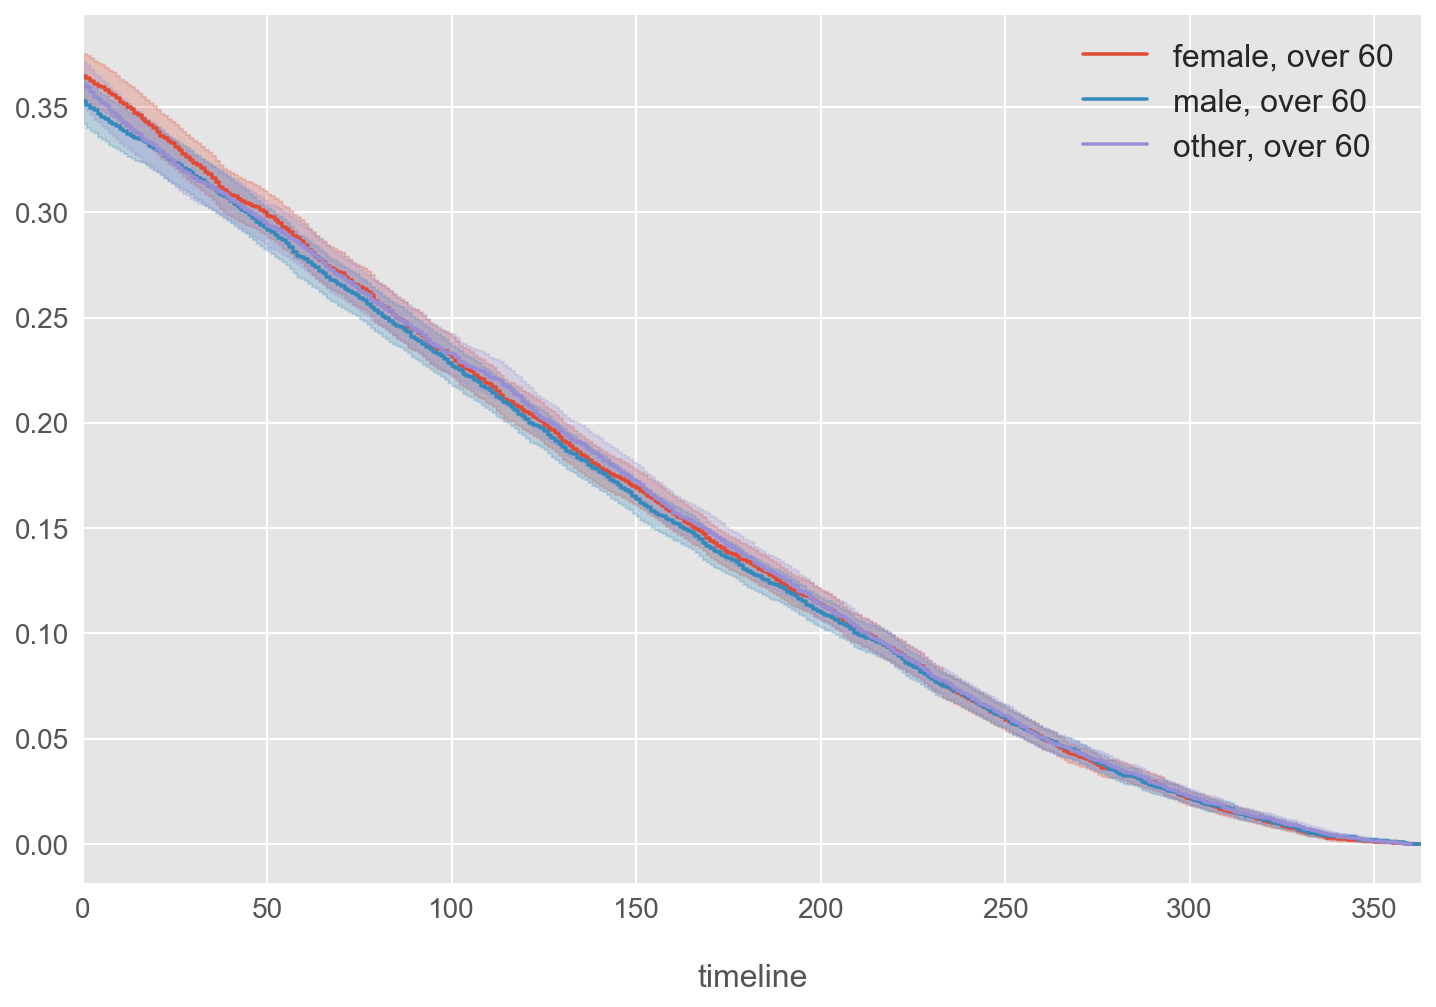

In [237]:
mask = (df_unique_users['age'] == 'over 60') & (df_unique_users['gender'] == 'female')
kmf.fit(df_unique_users[mask]['T'], df_unique_users[mask]['E'], label='female, over 60')
ax = kmf.plot()

mask2 = (df_unique_users['age'] == 'over 60') & (df_unique_users['gender'] == 'male')
kmf.fit(df_unique_users[mask2]['T'], df_unique_users[mask2]['E'], label='male, over 60')
ax = kmf.plot(ax=ax)

mask3 = (df_unique_users['age'] == 'over 60') & (df_unique_users['gender'] == 'other')
kmf.fit(df_unique_users[mask3]['T'], df_unique_users[mask3]['E'], label='other, over 60')
ax = kmf.plot(ax=ax)

In [218]:
df_unique_users.columns

Index(['date', 'visits', 'pageviews', 'transactions', 'transactionRevenue',
       'trafficSource', 'campaign', 'deviceType', 'browser', 'user_id',
       'region', 'age', 'gender', 'T', 'E'],
      dtype='object')

In [219]:
df_unique_users.age.unique()

array(['over 60', '35-45', '45-60', 'under 18', '25-35', '18-25'],
      dtype=object)

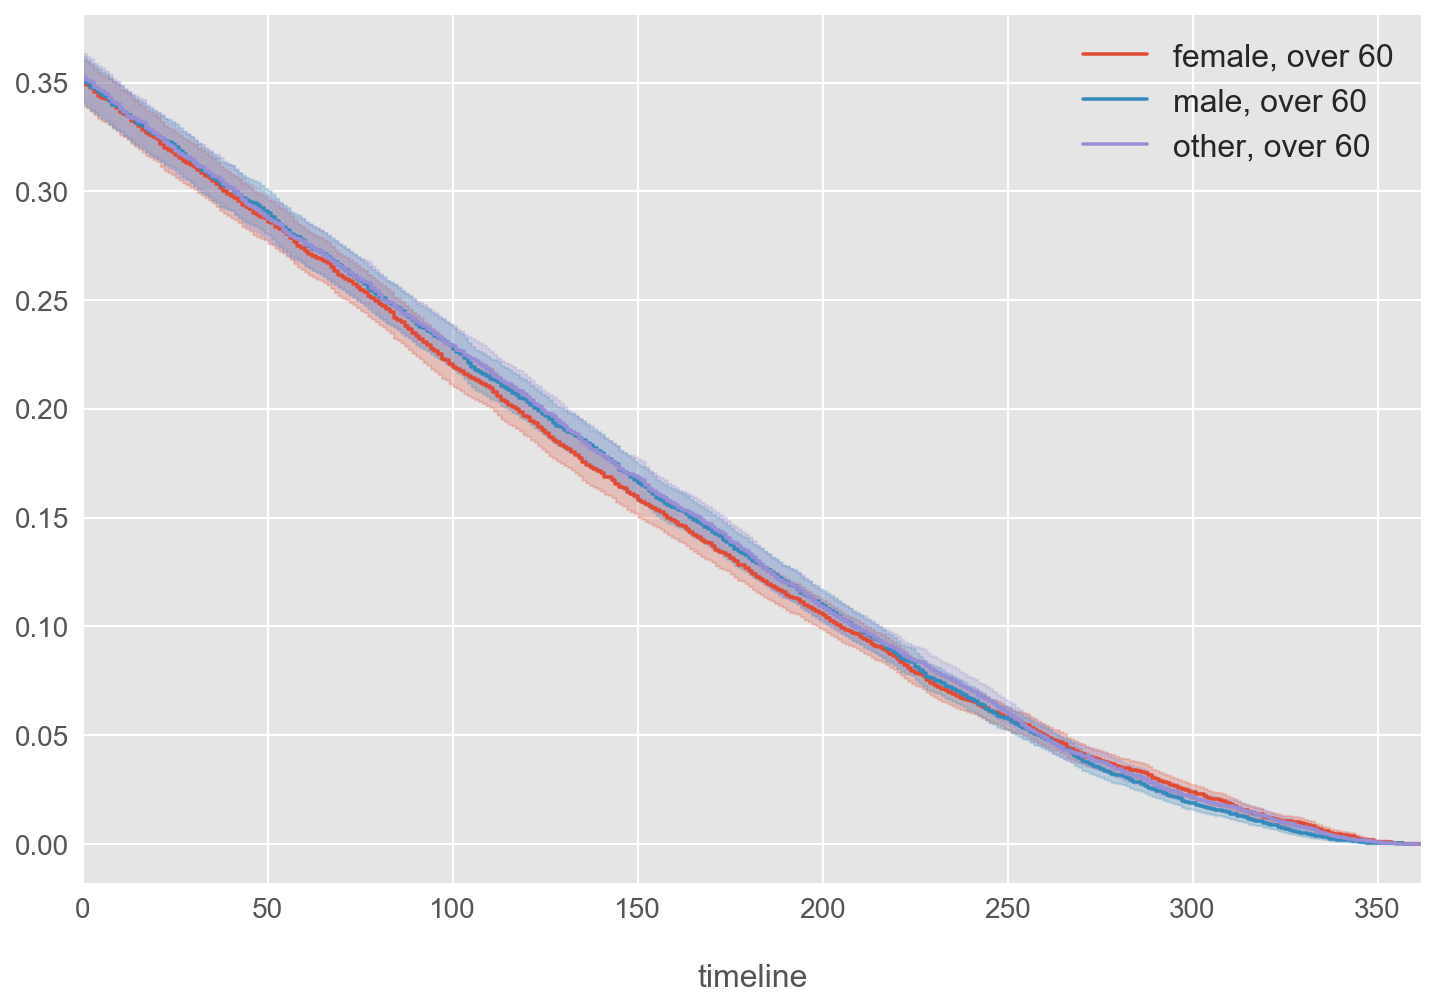

In [220]:
mask = (df_unique_users['age'] == 'under 18') & (df_unique_users['gender'] == 'female')
kmf.fit(df_unique_users[mask]['T'], df_unique_users[mask]['E'], label='female, over 60')
ax = kmf.plot()

mask2 = (df_unique_users['age'] == 'under 18') & (df_unique_users['gender'] == 'male')
kmf.fit(df_unique_users[mask2]['T'], df_unique_users[mask2]['E'], label='male, over 60')
ax = kmf.plot(ax=ax)

mask3 = (df_unique_users['age'] == 'under 18') & (df_unique_users['gender'] == 'other')
kmf.fit(df_unique_users[mask3]['T'], df_unique_users[mask3]['E'], label='other, over 60')
ax = kmf.plot(ax=ax)

            date  visits  pageviews  transactions  transactionRevenue  \
56348 2016-09-23       1        1.0           NaN                 NaN   
56349 2017-03-23       1        1.0           NaN                 NaN   

      trafficSource   campaign deviceType  browser  user_id    region  \
56348      (direct)  (not set)     mobile   Chrome        0  New York   
56349   youtube.com  (not set)    desktop  Firefox        0  New York   

            age gender    T  E  
56348  under 18   male  181  1  
56349  under 18   male    0  1  


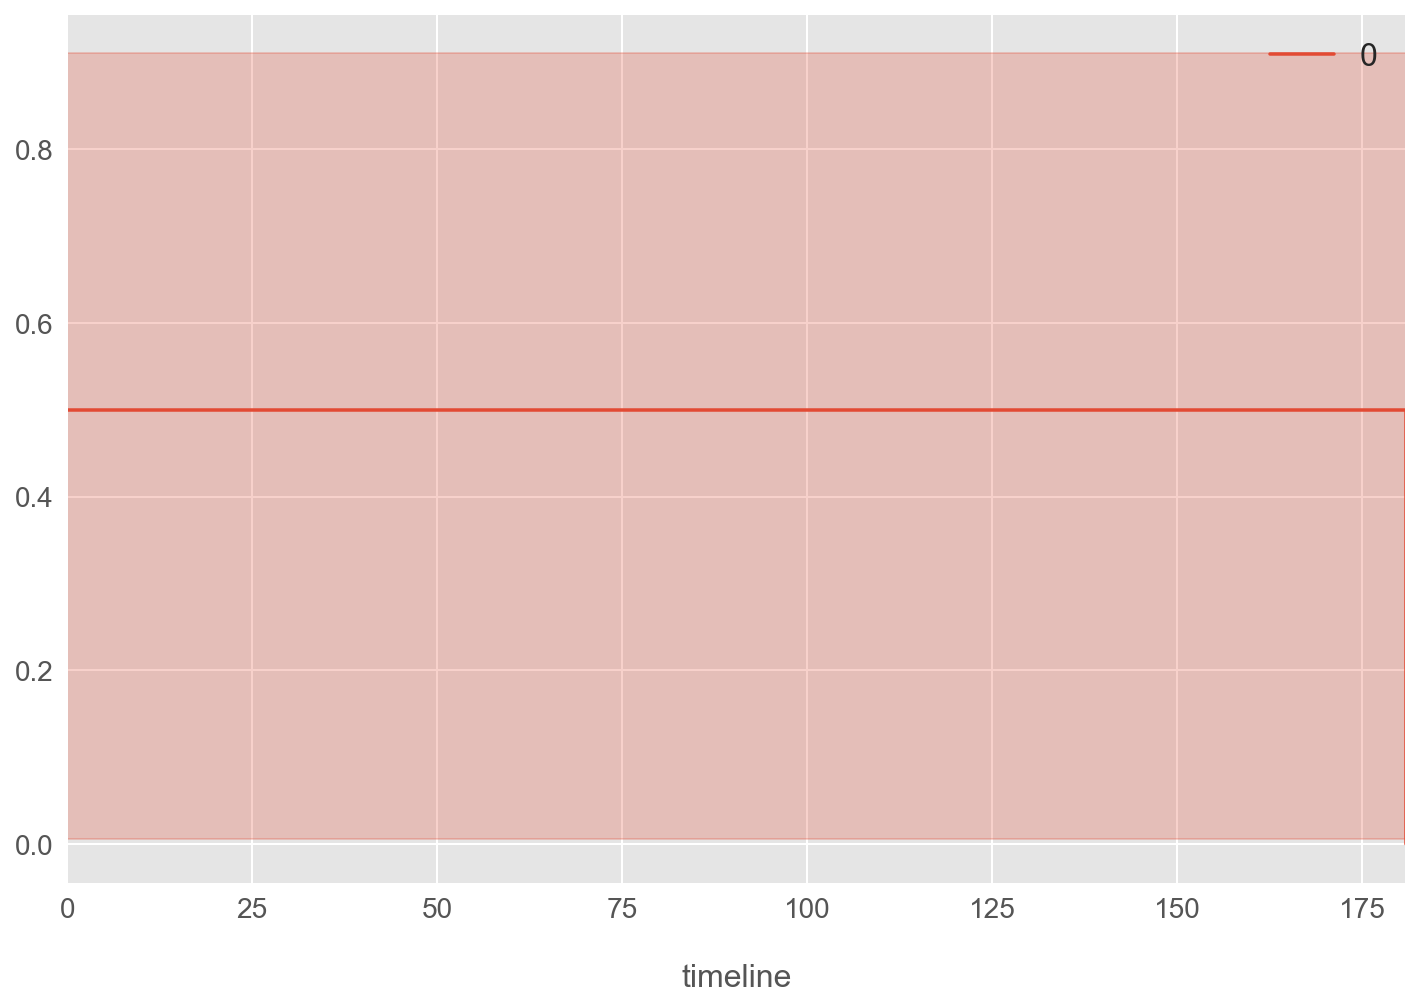

In [216]:
for name, grouped_df in df_regions_times2.groupby('user_id'):
    print(grouped_df)
    kmf.fit(grouped_df['T'], grouped_df['E'], label=name)
    kmf.plot()
    break

In [158]:
df_regions_times2['user_id'].value_counts()

527       9
20136     9
40221     8
17594     8
12816     8
11881     8
35051     8
24081     8
17852     8
3008      8
1850      8
1164      8
31248     8
13142     8
53614     8
27188     8
12954     8
25659     8
312       8
5402      8
6787      7
3412      7
2675      7
74904     7
13566     7
33296     7
13129     7
12826     7
17927     7
3997      7
         ..
96404     1
94357     1
92310     1
90263     1
333976    1
69785     1
67738     1
135289    1
946293    1
264250    1
237647    1
59        1
262376    1
22755     1
110814    1
245827    1
317505    1
10995     1
239694    1
223318    1
161908    1
221271    1
64963     1
190566    1
188519    1
165994    1
163947    1
108765    1
106716    1
421902    1
Name: user_id, Length: 135206, dtype: int64

In [138]:
from lifelines import *
wbf = WeibullFitter().fit(graph_df['T'], graph_df['E'], label='WeibullFitter')

ValueError: This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.

Observed lifetimes at time 10:
 [ 4.4157142   9.33837138  3.99603454  1.40865581  0.40591024  0.44622221
  6.94143734 10.          2.94130188  1.36474645  0.49131183  0.11164691
  7.29363301  4.05808591  7.3489645   1.06176323  4.40727916  0.69945183
  3.02651653  7.88703555  2.87036316  1.86568456  2.51641198  0.12939337
  3.54365927]


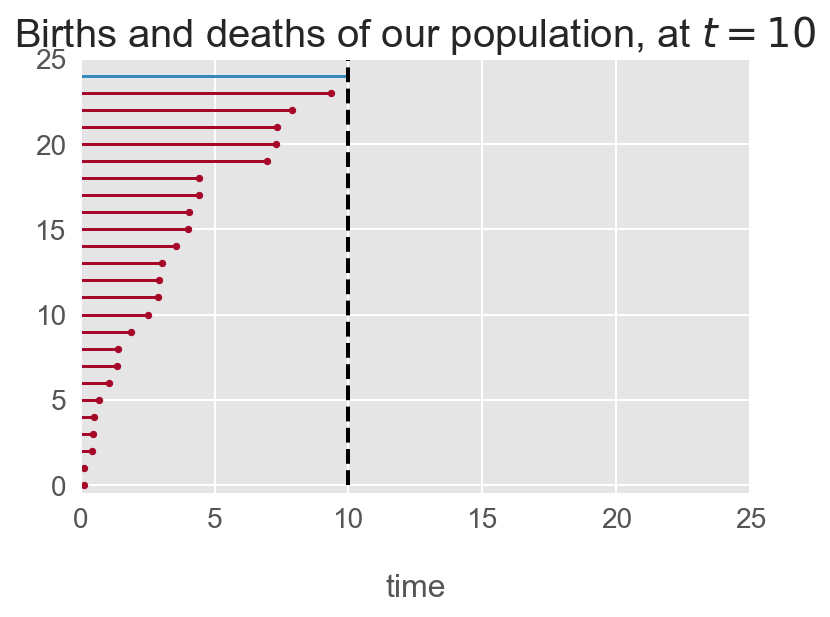

In [11]:
N = 25

CURRENT_TIME = 10

actual_lifetimes = np.array([
    exponential(12) if (uniform() < 0.5) else exponential(2) for i in range(N)
])
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)
ax.set_xlim(0, 25)
ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Births and deaths of our population, at $t=10$")
print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)
